# Using Empath to Analyse Reflection in DTRS Datasets

In [1]:
import sys
import re
import glob
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
from empath import Empath
from scipy import stats
from IPython.display import Markdown, display

In [2]:
def printmd(string):
    display(Markdown(string))

## Load All DTRS Datasets
If the below function does not work, check your "output" folder to make sure all files are present. The code should load 65 files into the dataframe.

In [3]:
files = glob.glob('./output/*.txt')

df_list = []

for filename in files:
    df_file = pd.read_csv(filename, sep=';')
    df_list.append(df_file)

df = pd.concat(df_list, axis=0, ignore_index=True)
print("Read", len(files), "files and loaded", df.shape[0], "rows into the dataframe.")

Read 65 files and loaded 20900 rows into the dataframe.


## Manage Categories in Empath
Some functions for keeping track of original categories present in Empath and new ones that you create.

In [4]:
def check_for_custom_caetgories():
    current_lexicon = Empath()
    empath_original_categories_list = [
         'achievement', 'affection', 'aggression', 'air_travel', 'alcohol', 'ancient', 'anger',
         'animal', 'anonymity', 'anticipation', 'appearance', 'art', 'attractive', 'banking',
         'beach', 'beauty', 'blue_collar_job', 'body', 'breaking', 'business', 'car',
         'celebration', 'cheerfulness', 'childish', 'children', 'cleaning', 'clothing', 'cold',
         'college', 'communication', 'competing', 'computer', 'confusion', 'contentment',
         'cooking', 'crime', 'dance', 'death', 'deception', 'disappointment', 'disgust',
         'dispute', 'divine', 'domestic_work', 'dominant_heirarchical', 'dominant_personality',
         'driving', 'eating', 'economics', 'emotional', 'envy', 'exasperation', 'exercise',
         'exotic', 'fabric', 'family', 'farming', 'fashion', 'fear', 'feminine', 'fight',
         'fire', 'friends', 'fun', 'furniture', 'gain', 'giving', 'government', 'hate',
         'healing', 'health', 'hearing', 'help', 'heroic', 'hiking', 'hipster', 'home',
         'horror', 'hygiene', 'independence', 'injury', 'internet', 'irritability',
         'journalism', 'joy', 'kill', 'law', 'leader', 'legend', 'leisure', 'liquid', 'listen',
         'love', 'lust', 'magic', 'masculine', 'medical_emergency', 'medieval', 'meeting',
         'messaging', 'military', 'money', 'monster', 'morning', 'movement', 'music',
         'musical', 'negative_emotion', 'neglect', 'negotiate', 'nervousness', 'night',
         'noise', 'occupation', 'ocean', 'office', 'optimism', 'order', 'pain', 'party',
         'payment', 'pet', 'philosophy', 'phone', 'plant', 'play', 'politeness', 'politics',
         'poor', 'positive_emotion', 'power', 'pride', 'prison', 'programming', 'rage',
         'reading', 'real_estate', 'religion', 'restaurant', 'ridicule', 'royalty', 'rural',
         'sadness', 'sailing', 'school', 'science', 'sexual', 'shame', 'shape_and_size',
         'ship', 'shopping', 'sleep', 'smell', 'social_media', 'sound', 'speaking', 'sports',
         'stealing', 'strength', 'suffering', 'superhero', 'surprise', 'swearing_terms',
         'swimming', 'sympathy', 'technology', 'terrorism', 'timidity', 'tool', 'torment',
         'tourism', 'toy', 'traveling', 'trust', 'ugliness', 'urban', 'vacation', 'valuable',
         'vehicle', 'violence', 'war', 'warmth', 'water', 'weakness', 'wealthy', 'weapon',
         'weather', 'wedding', 'white_collar_job', 'work', 'worship', 'writing', 'youth', 'zest'
    ]
    empath_original_set = set(empath_original_categories_list)
    empath_current_set = set(lexicon.cats.keys())
    new_categories = empath_current_set.difference(empath_original_set)
    return new_categories
    

def delete_custom_categories():
    cats_to_delete = check_for_custom_caetgories()
    empath_lexicon = Empath()
    for cat in list(cats_to_delete) :
        empath_lexicon.delete_category(cat)
    print("Categories Deleted: ")
    print(cats_to_delete)
        

## Create your own Empath Category
Make sure the category name is an English word, it can help. Read the original paper for details on how.
#### FOR VERA:
Experiment with different seed terms to see what works best for you.

In [5]:
lexicon = Empath()
lexicon.create_category('reflection', ['i', 'have', 'me', 'my', 'feel', 'felt','not', 'that', 'more', 'better', 'this', 'believe','now', 'future', 'of', 'was', 'situation', 'think','are', 'if', 'would', 'and', 'but', 'never','but', 'could', 'aware', 'hindsight', 'learnt', 'although','probably', 'it', 'myself'], size=100)

["though", "though", "only", "actually", "probably", "knowing", "knew", "thought", "Because", "although", "Yet", "seeing", "'d", "meant", "someone", "Though", "more", "might", "anything", "Although", "honestly", "yet", "possibly", "yet", "always", "wanted", "However", "fact", "Maybe", "things", "Even", "should", "surely", "Now", "somehow", "being", "person", "feel", "anymore", "If", "either", "else", "nothing", "anyway", "maybe", "anyone", "own", "everything", "especially", "Or", "one", "either", "people"]


In [39]:
check_for_custom_caetgories()

{'reflection'}

In [40]:
#delete_custom_categories()

## Get Words from New Category
We will not be using Empath's default matching functions, so that we can do a bit more that what Empath functions allow (identify matching words, create plots, etc.). So we create our own regular expression matching which can definitely be improved upon (see if you want to work on this!)

In [41]:
reflection_words = lexicon.cats['reflection']
reflection_words = [w.lower() for w in reflection_words]
reflection_words = sorted(list(set(reflection_words)))
reflection_words = [w.replace("_", " ") for w in reflection_words]

In [42]:
def make_regex(lex_list):
    separator = '\\b|\\b'
    reg_string = separator.join(lex_list)
    reg_string_whole_word = "\\b" + reg_string + "\\b"
    return reg_string_whole_word

def count_lexicon_terms(sentence, lexicon):
    reg_str = make_regex(lexicon)
    num_matches = len(list(re.finditer(reg_str, sentence.lower())))
    return num_matches

def count_words(sentence):
    words = sentence.split()
    return len(words)

## Add the number of matches to the dataframe
We use total matches here, but we also keep a count of words so that we can normalize later if needed.

In [43]:
df[0:10]

,dataset,session,speaker,utterance,reflection,word count
0,dtrs-10,grad-2-concept-review-sharon,Steve,Next. Okay whose turn? Wilson?,0,5
1,dtrs-10,grad-2-concept-review-sharon,Wilson,Huh?,0,1
2,dtrs-10,grad-2-concept-review-sharon,Steve,"You’re talking, it’s your turn.",0,5
3,dtrs-10,grad-2-concept-review-sharon,Wilson,It’s my turn?,0,3
4,dtrs-10,grad-2-concept-review-sharon,Steve,You critique it. What’s working. Explain the...,0,8
5,dtrs-10,grad-2-concept-review-sharon,Wilson,Let me take a look. Uh. So it is uh a coat h...,0,64
6,dtrs-10,grad-2-concept-review-sharon,Steve,"OK. It makes sense. Okay, what is good about...",1,20
7,dtrs-10,grad-2-concept-review-sharon,Wilson,I think the storyboard it make very good sense.,0,9
8,dtrs-10,grad-2-concept-review-sharon,Steve,Okay.,0,1
9,dtrs-10,grad-2-concept-review-sharon,Wilson,Yes.,0,1


In [44]:
def add_measure(df, lex_category_name, lex_category_list, normalize_measure=False):
    if lex_category_name in df.columns :
        print("Column already exists for", lex_category_name, ". Repopulating...")
        df = df.drop(lex_category_name, axis=1)
    column_index = len(df.columns)
    empath_measures = []
    word_counts = []
    for ind, utterance in enumerate(list(df['utterance'])) :
        if utterance != '' and utterance != ' ' :
            empath_measure = count_lexicon_terms(utterance, lex_category_list)
            num_words = count_words(utterance)
            word_counts.append(num_words)
            if normalize_measure :
                empath_measures.append(empath_measure/num_words)
            else :
                empath_measures.append(empath_measure)
    df.insert(column_index, lex_category_name, empath_measures, True)
    if not 'word count' in df.columns :
        df.insert(column_index+1, 'word count', word_counts, True)
    return df


In [45]:
df = add_measure(df, 'reflection', reflection_words, normalize_measure=False)
df[0:10]

Column already exists for reflection . Repopulating...


,dataset,session,speaker,utterance,word count,reflection
0,dtrs-10,grad-2-concept-review-sharon,Steve,Next. Okay whose turn? Wilson?,5,0
1,dtrs-10,grad-2-concept-review-sharon,Wilson,Huh?,1,0
2,dtrs-10,grad-2-concept-review-sharon,Steve,"You’re talking, it’s your turn.",5,0
3,dtrs-10,grad-2-concept-review-sharon,Wilson,It’s my turn?,3,0
4,dtrs-10,grad-2-concept-review-sharon,Steve,You critique it. What’s working. Explain the...,8,0
5,dtrs-10,grad-2-concept-review-sharon,Wilson,Let me take a look. Uh. So it is uh a coat h...,64,1
6,dtrs-10,grad-2-concept-review-sharon,Steve,"OK. It makes sense. Okay, what is good about...",20,1
7,dtrs-10,grad-2-concept-review-sharon,Wilson,I think the storyboard it make very good sense.,9,0
8,dtrs-10,grad-2-concept-review-sharon,Steve,Okay.,1,0
9,dtrs-10,grad-2-concept-review-sharon,Wilson,Yes.,1,0


## Plot Occurrences
A number of plotting functions to plot occurrences by dataset, by session, by speaker, and on a timeline. 

In [46]:
def plot_cats_by_dataset(df, category, normalize=False):
    dataset_df = df
    dataset_category_df = df[df[category] > 0]
    datasets = sorted(list(set(df['dataset'])))
    num_datasets = len(datasets)
    fig = plt.figure(figsize=[num_datasets,4], dpi=300)
    if normalize == False :
        p=sns.countplot(data=dataset_df, x='dataset', color='#eee', order=datasets)
        p=sns.countplot(data=dataset_category_df, x='dataset', color='#777', order=datasets)
        p.set_title('proportion of ' + category + ' turns')
    else :
        total_turns_list = []
        category_turns_list = []
        for dataset in datasets :
            total_turns = df[df['dataset'] == dataset].shape[0]
            category_turns = dataset_category_df[dataset_category_df['dataset'] == dataset].shape[0]
            total_turns_normalized = 100
            category_turns_normalized = category_turns/total_turns * 100
            total_turns_list.append(total_turns_normalized)
            category_turns_list.append(category_turns_normalized)
        p=sns.barplot(x=datasets, y=total_turns_list, orient='v', color='#eee')
        p=sns.barplot(x = datasets, y=category_turns_list, orient='v', color='#777')
        p.set_title('proportion of ' + category + ' turns')
        
    plt.savefig('plots/empath'+category+'-turns-count.pdf', bbox_inches='tight')
    plt.show()


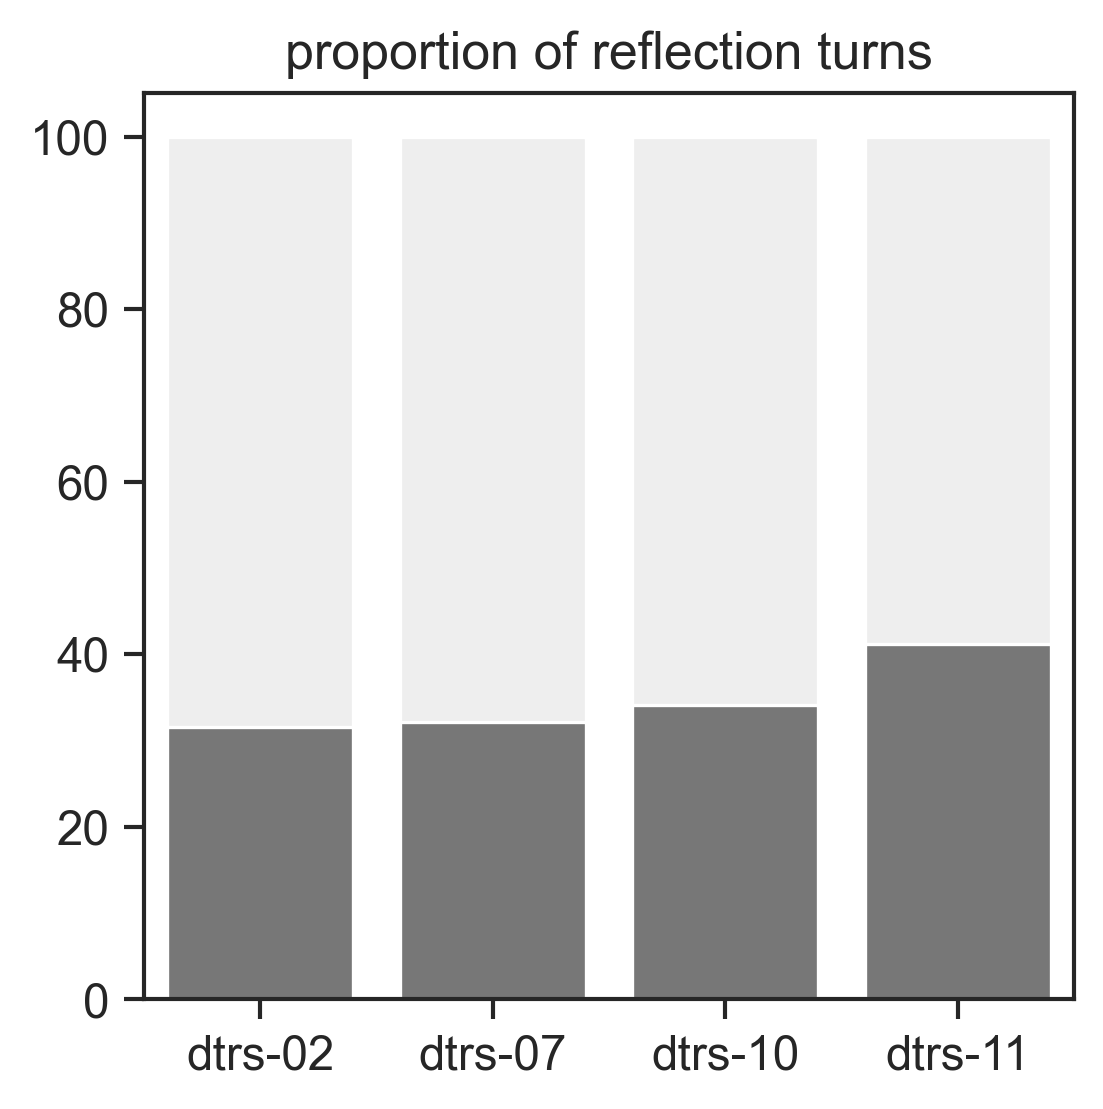

In [47]:
plot_cats_by_dataset(df, 'reflection', normalize=True)


In [48]:
def plot_cats_by_session(df, dataset_name, category, color='default', normalize=False):
    dataset_df = df[df['dataset'] == dataset_name]
    dataset_category_df = dataset_df[dataset_df[category] > 0]
    sessions = sorted(list(set(dataset_df['session'])))
    num_sessions = len(sessions)
    fig = plt.figure(figsize=[num_sessions,4], dpi=300)
    if normalize == False :
        p=sns.countplot(data=dataset_df, x='session', color='#eee', order=sessions)
        p=sns.countplot(data=dataset_category_df, x='session', color='#777', order=sessions)
        p.set_title('proportion of ' + category + ' turns')
    else :
        total_turns_list = []
        category_turns_list = []
        for session in sessions :
            total_turns = dataset_df[dataset_df['session'] == session].shape[0]
            category_turns = dataset_category_df[dataset_category_df['session'] == session].shape[0]
            total_turns_normalized = 100
            category_turns_normalized = category_turns/total_turns * 100
            total_turns_list.append(total_turns_normalized)
            category_turns_list.append(category_turns_normalized)
        p=sns.barplot(x=sessions, y=total_turns_list, orient='v', color='#eee')
        p=sns.barplot(x = sessions, y=category_turns_list, orient='v', color='#777')
    p.set_title('proportion of ' + category + ' turns')
    p.set_xticklabels(sessions, rotation=30, ha='right')
    plt.savefig('plots/empath'+category+'-'+dataset_name+'-turns-count-by-session.pdf', bbox_inches='tight')
    plt.show()


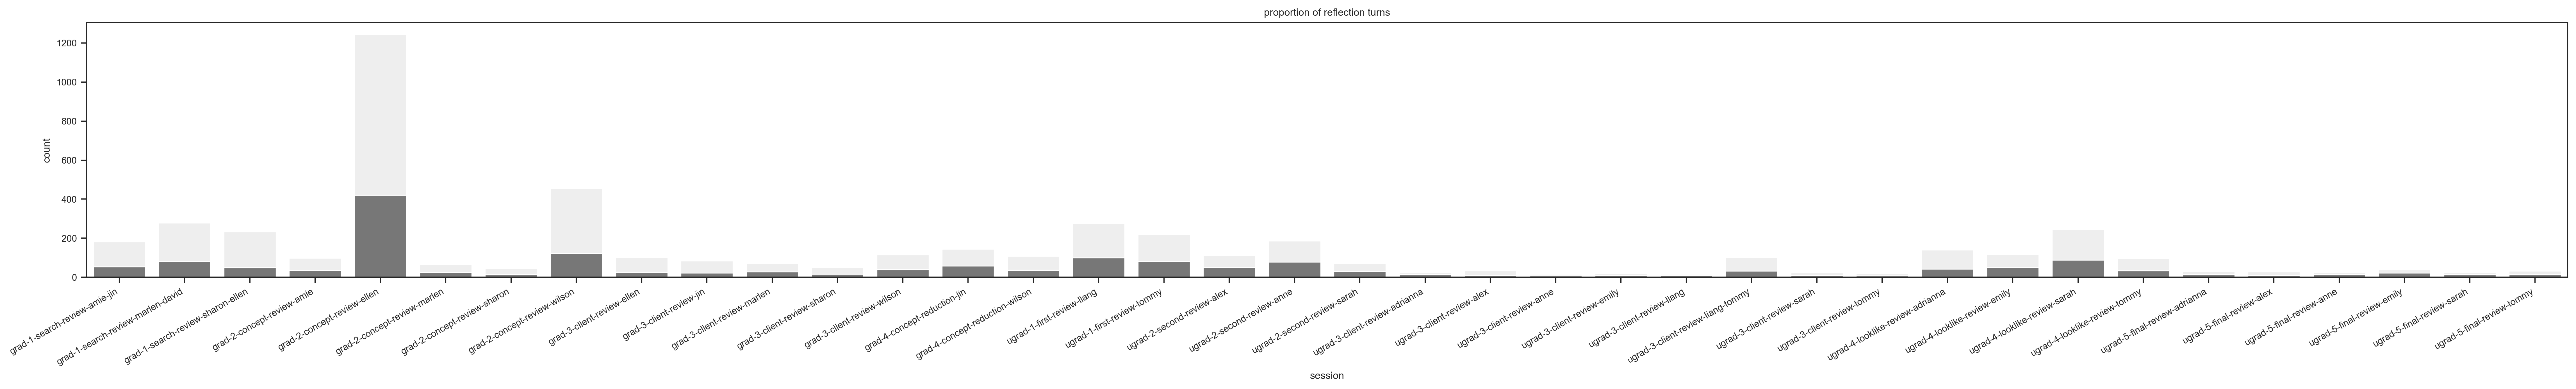

In [59]:
sns.set_context("paper", font_scale=0.9)
plot_cats_by_session(df, 'dtrs-10', 'reflection', normalize=False)


In [60]:
def plot_cats_by_speaker(df, dataset, category):
    sessions = list(set(df[df['dataset'] == dataset]['session']))
    for session in sessions :
        session_df = df[df['session'] == session]
        session_category_df = df[(df['session'] == session) & (df[category] > 0)]
        speakers = sorted(list(set(session_df['speaker'])))
        num_speakers = len(speakers)
        fig = plt.figure(figsize=[num_speakers,4], dpi=300)
        p=sns.countplot(data=session_df, x='speaker', color='#eee', order=speakers)
        p=sns.countplot(data=session_category_df, x='speaker', color='#777', order=speakers)
        p.set_title(category + ' turns count | ' + dataset + ' | ' + session)
        plt.savefig('plots/empath'+category+'-turns-count-'+ dataset +'-'+ session +'.pdf', bbox_inches='tight')
        plt.show()


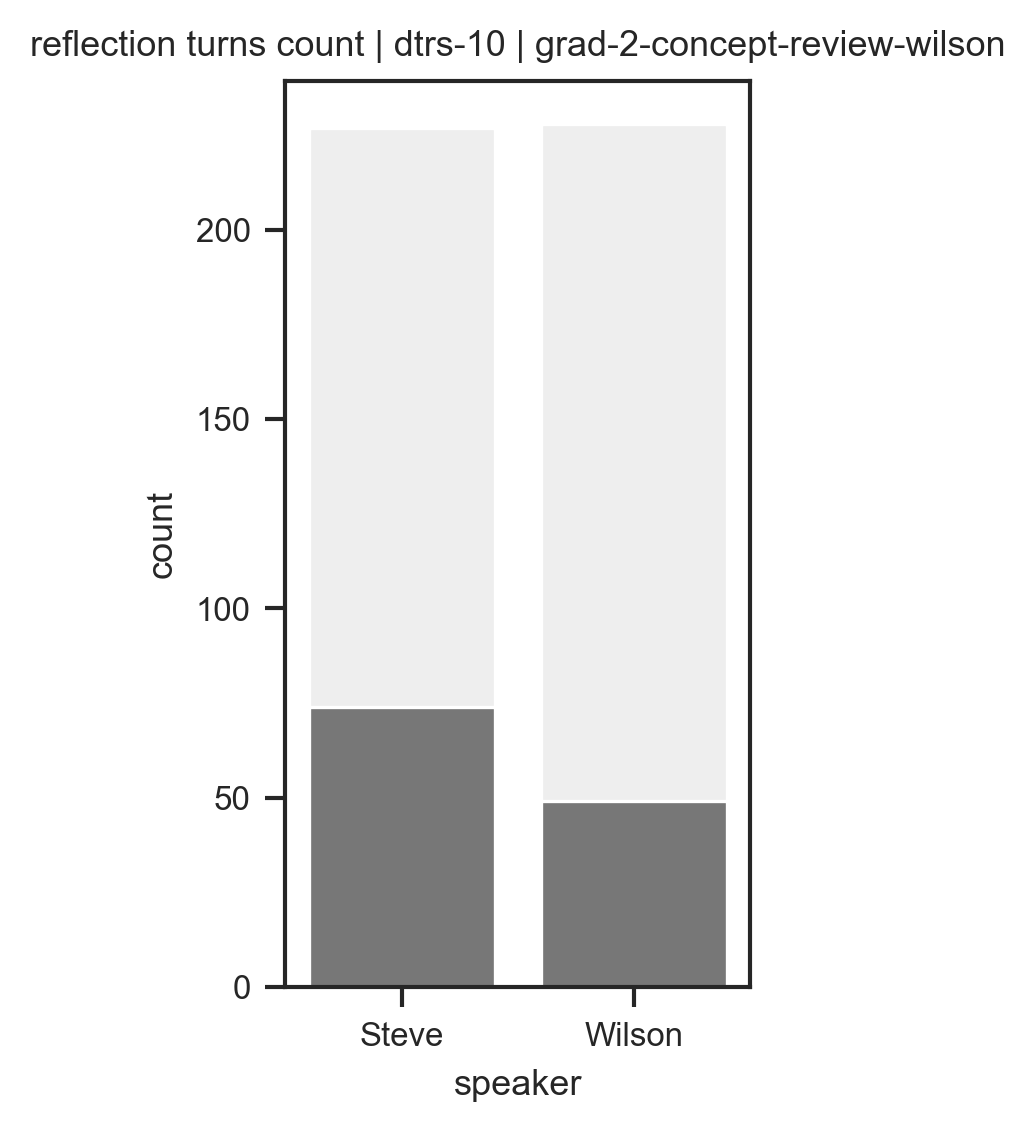

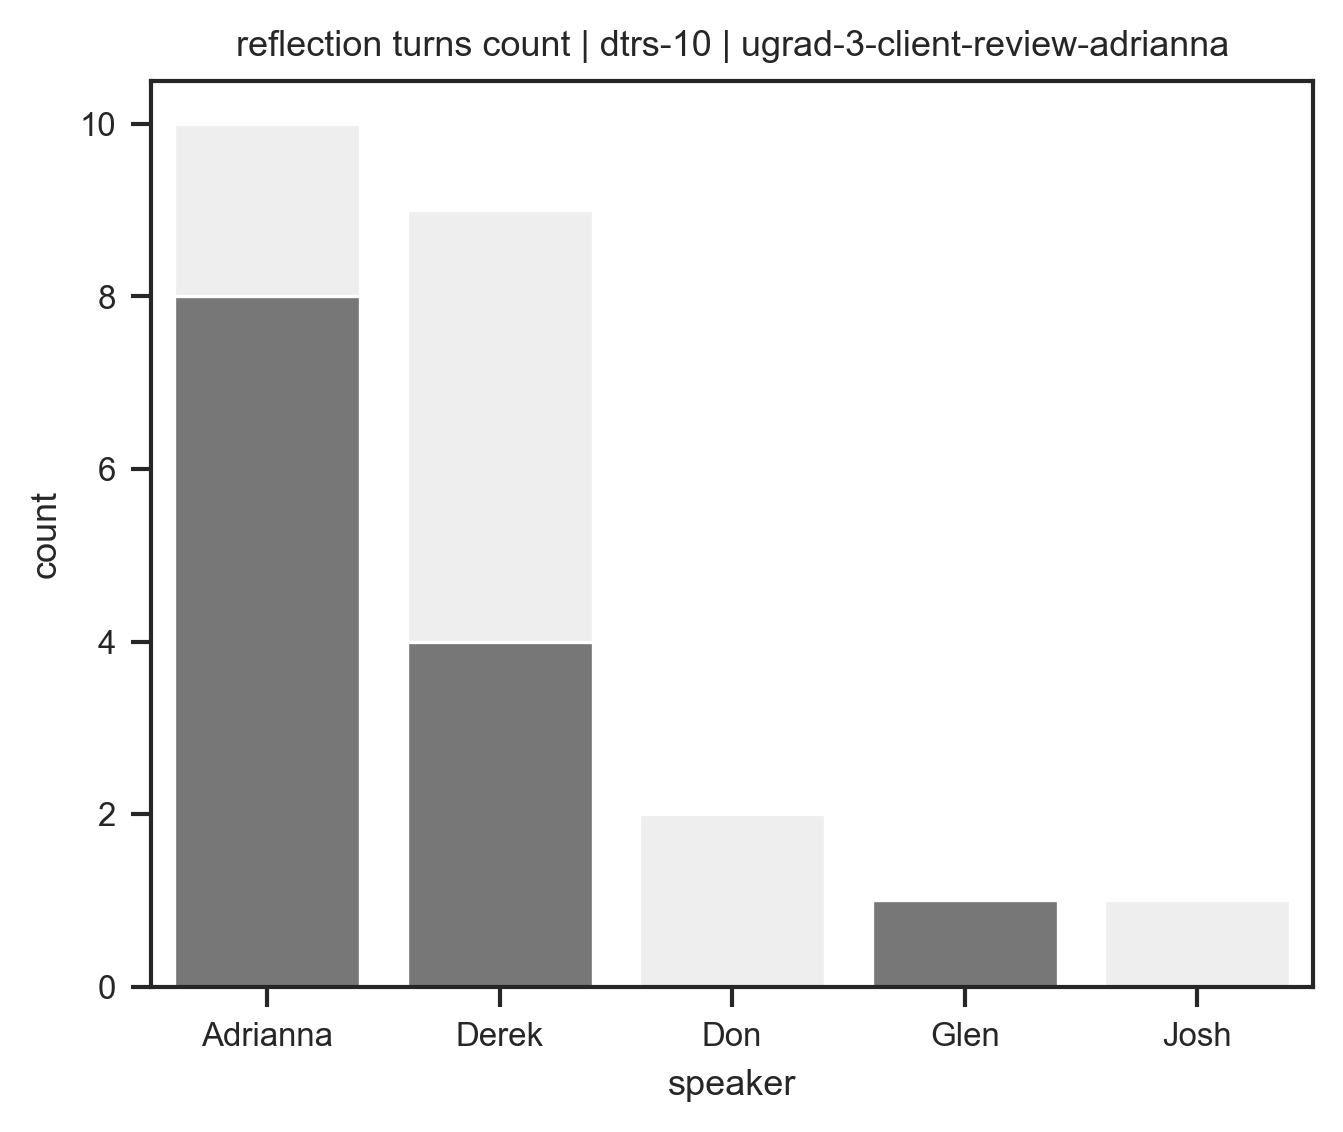

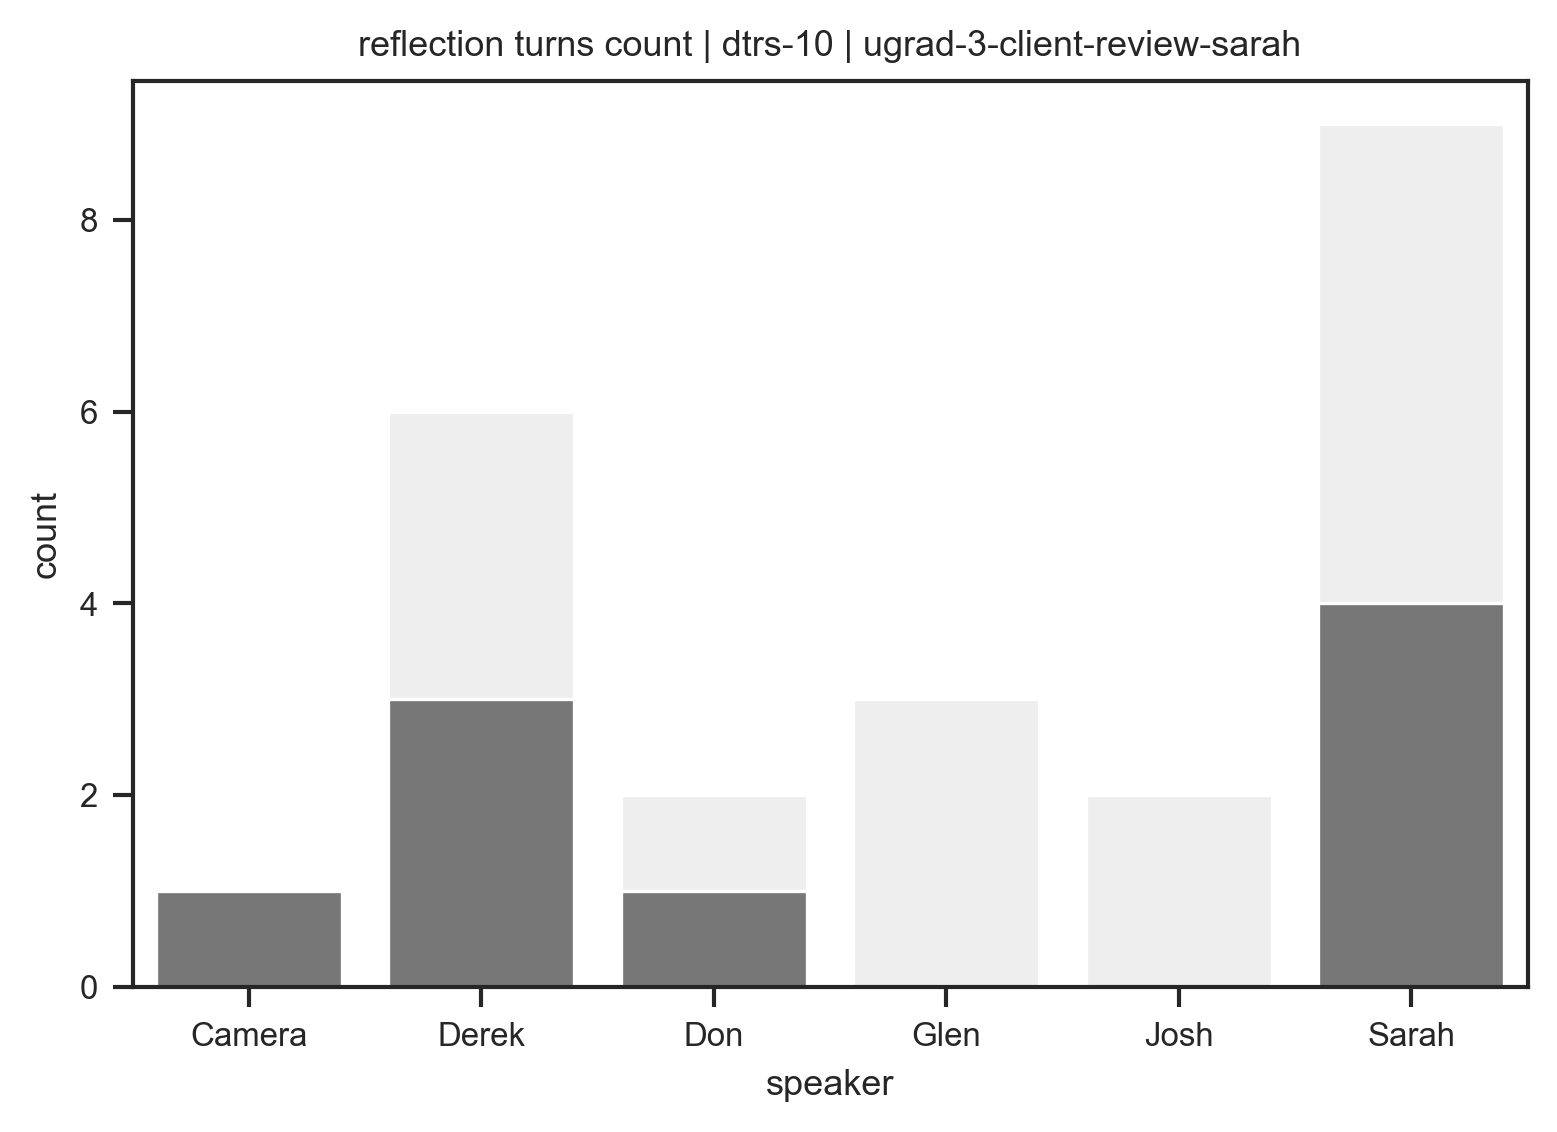

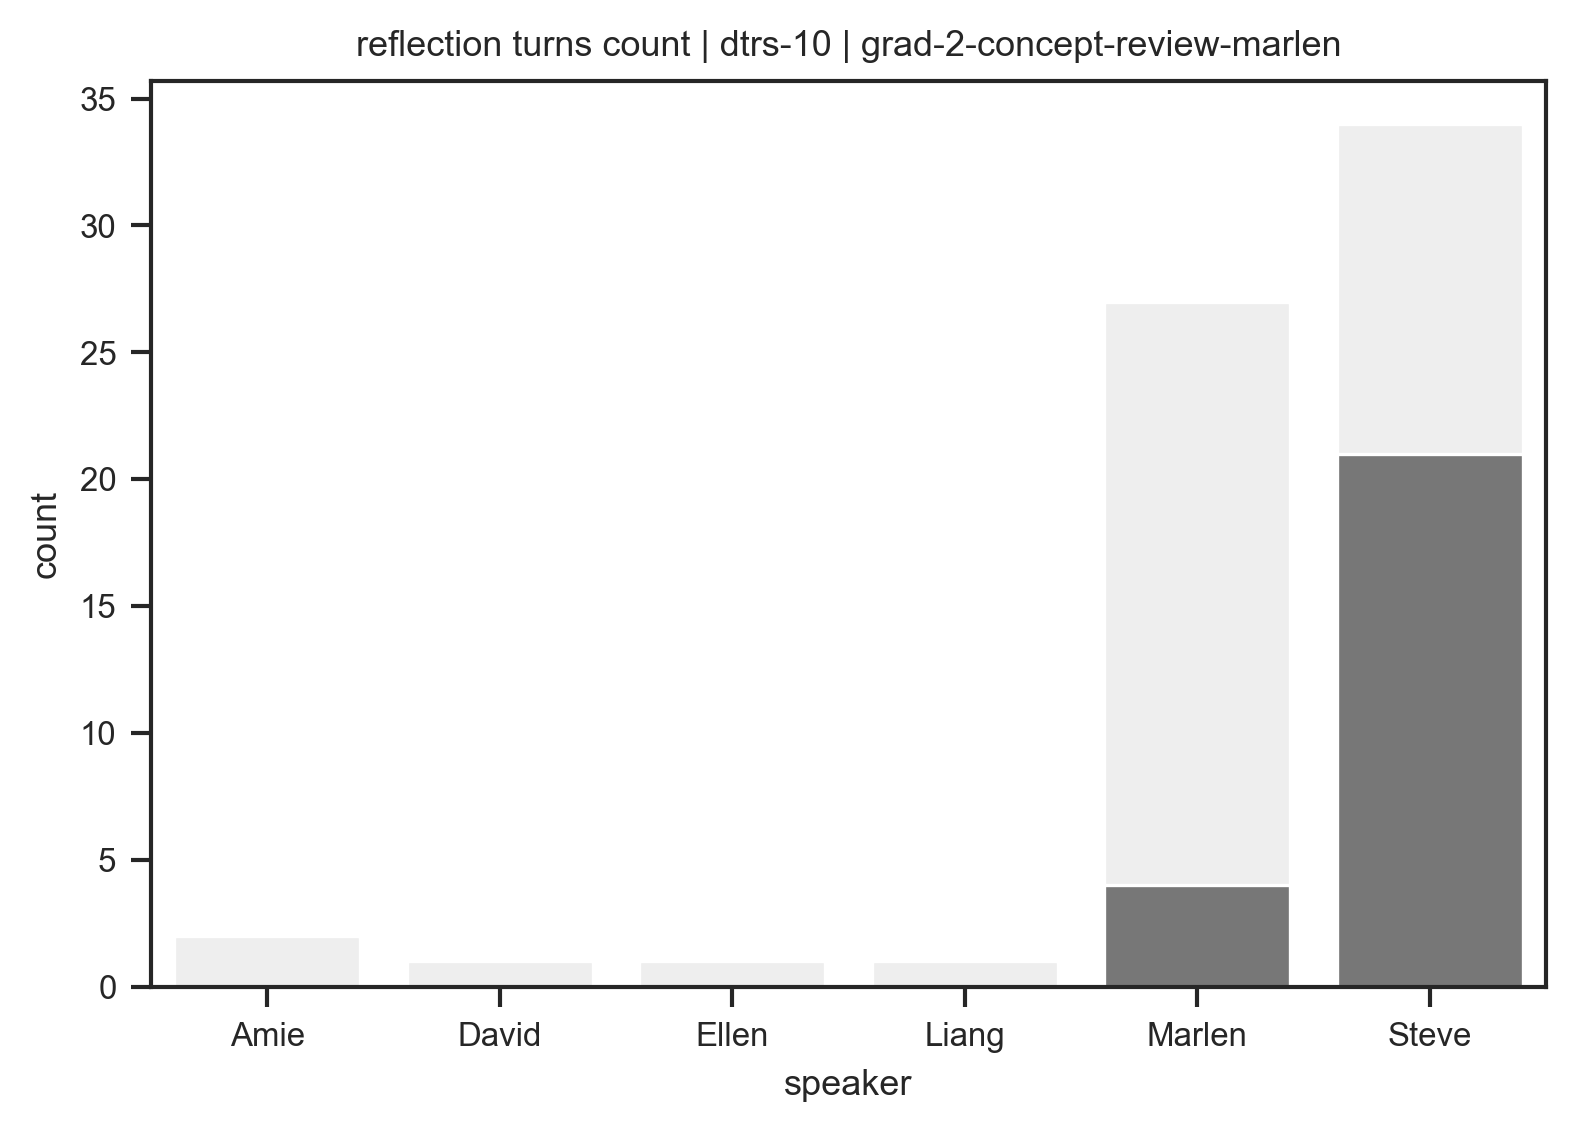

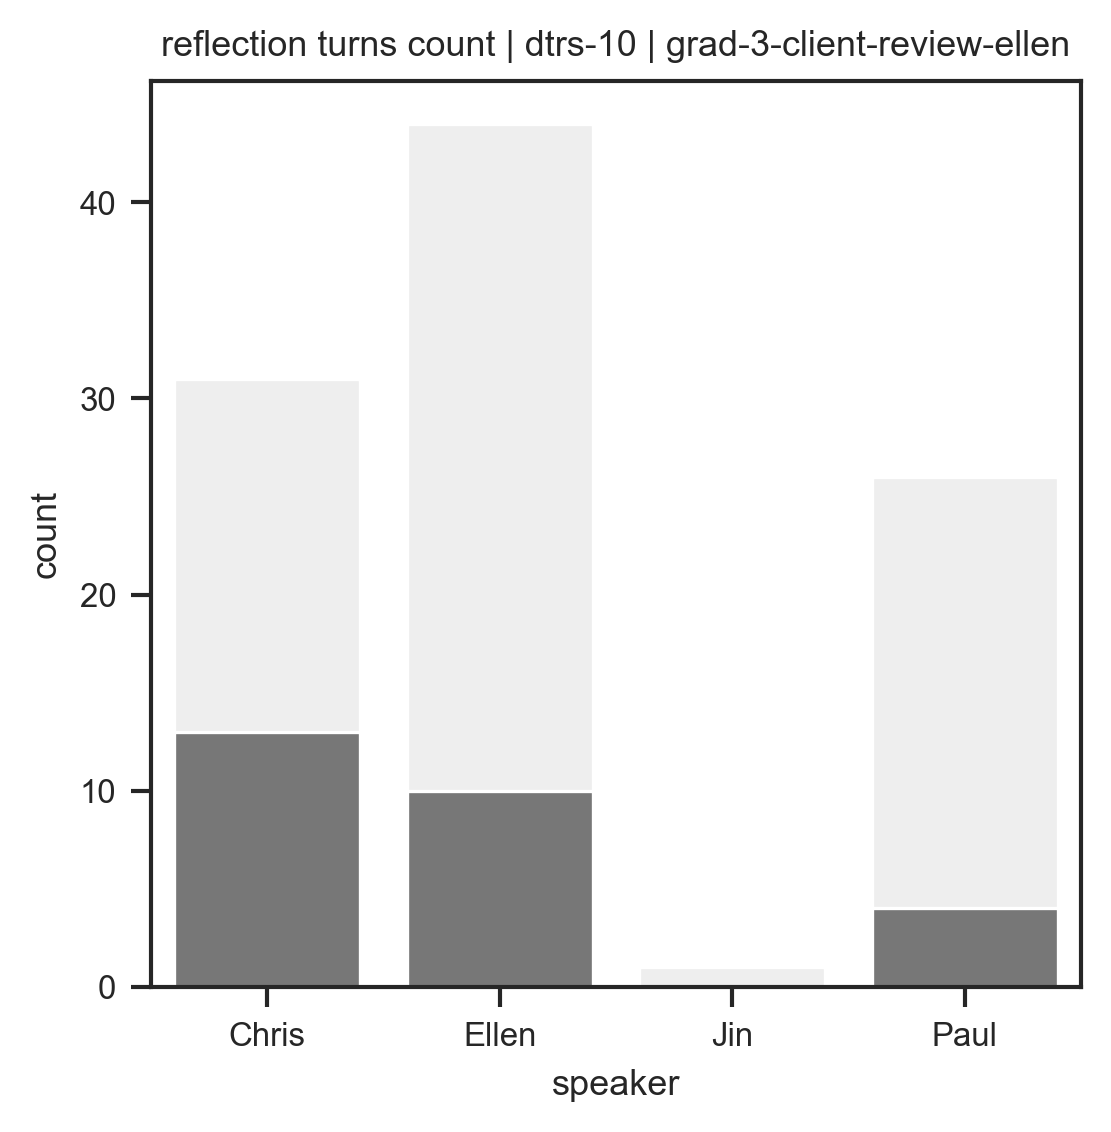

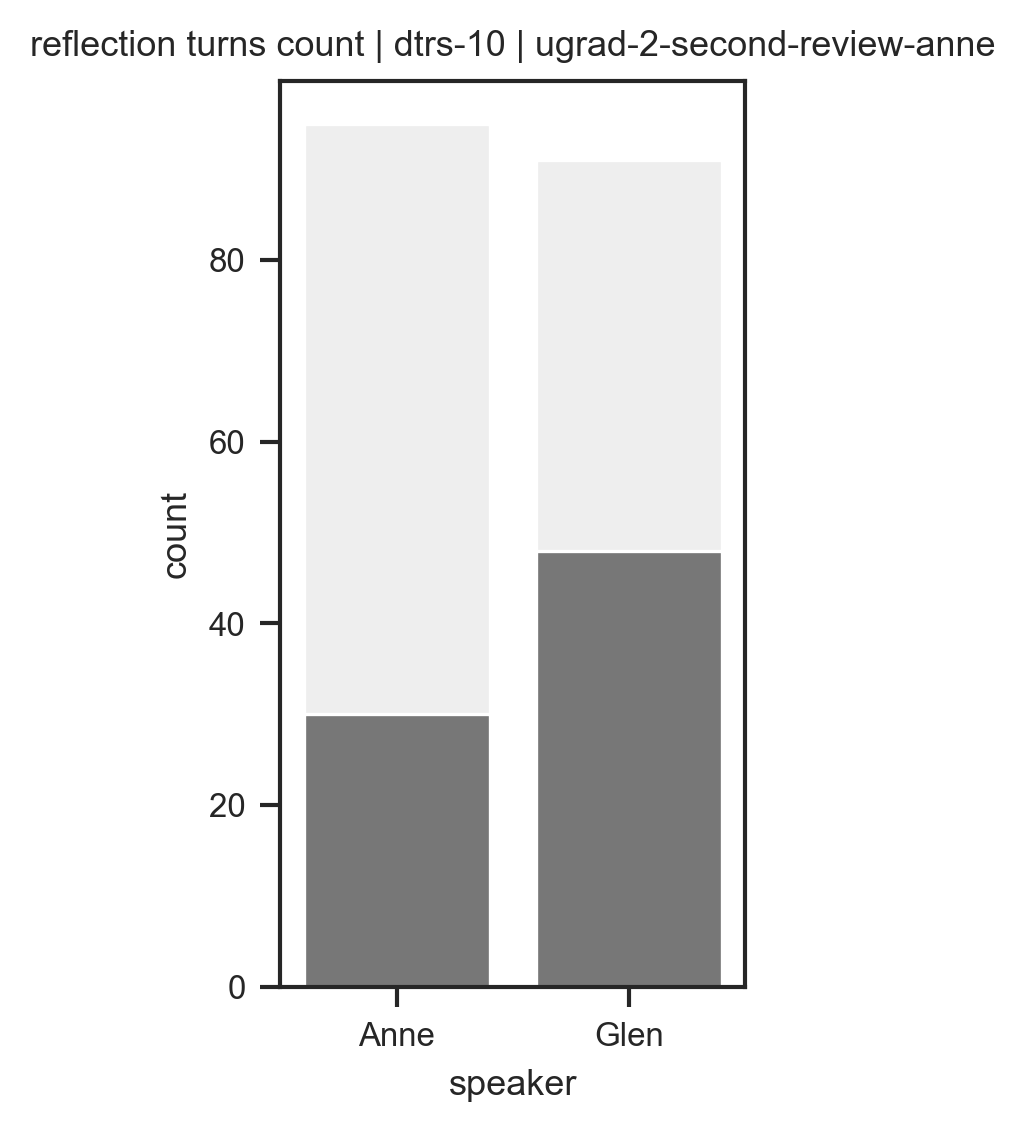

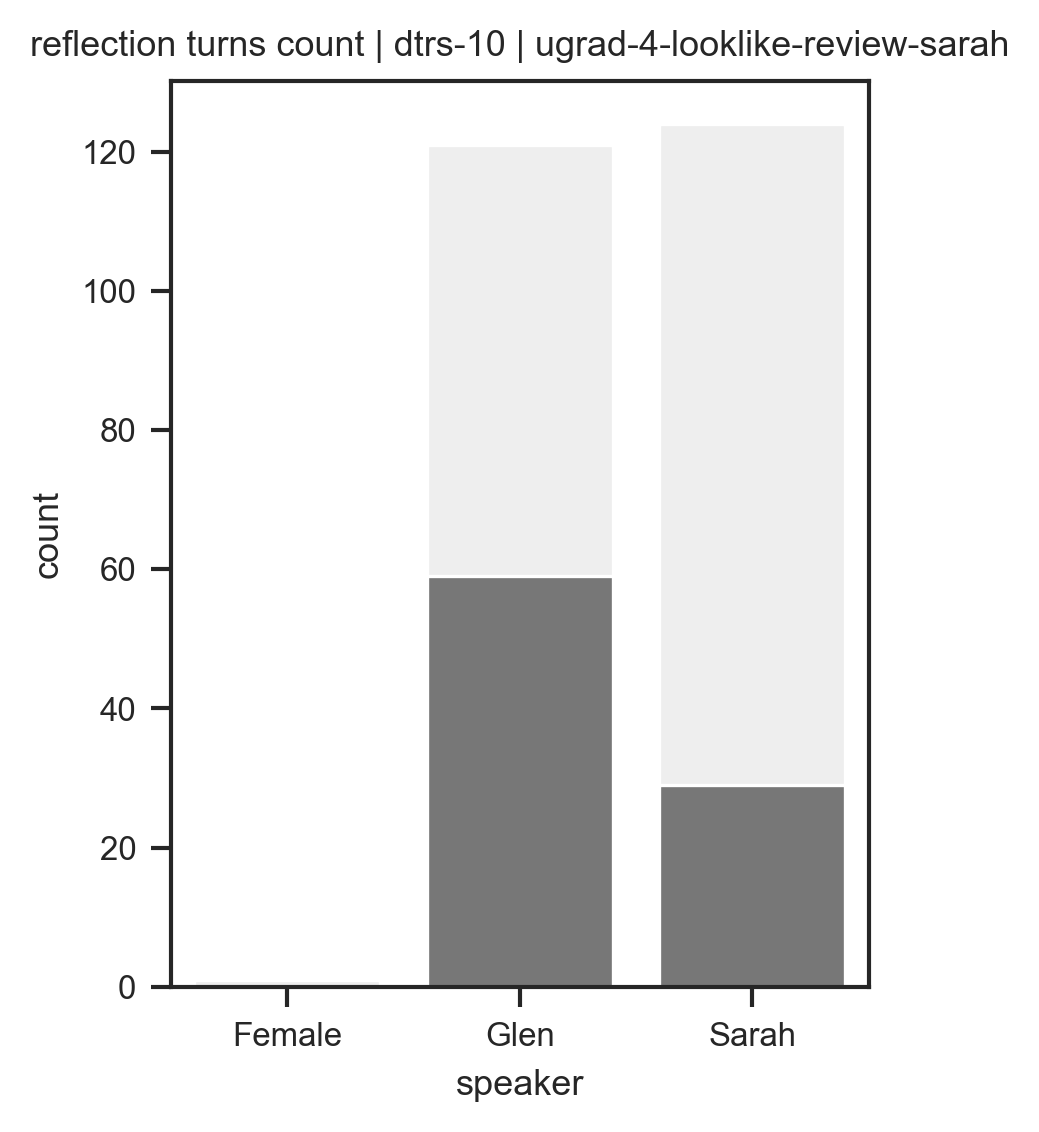

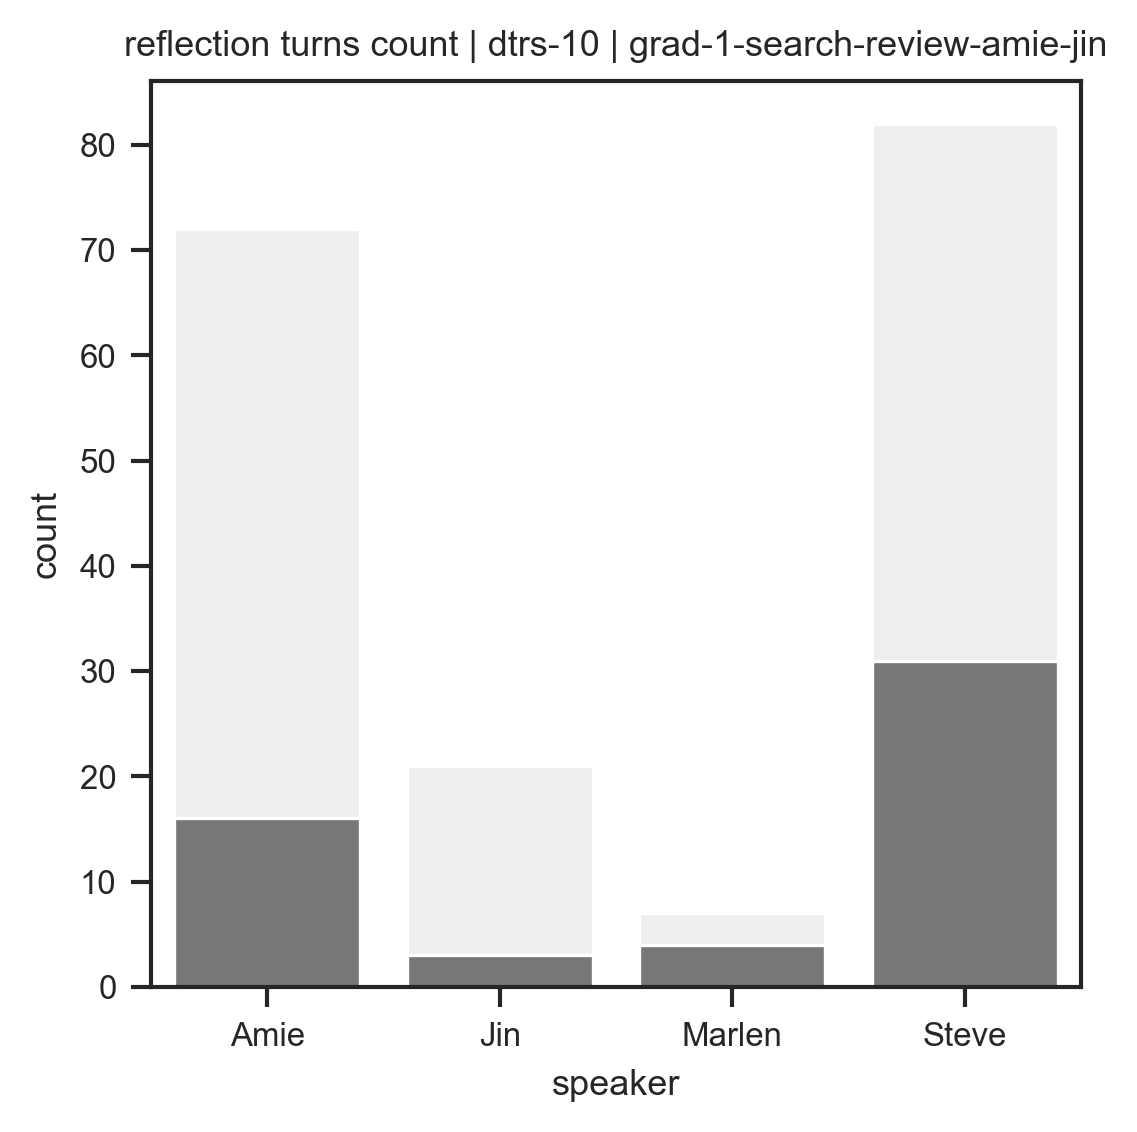

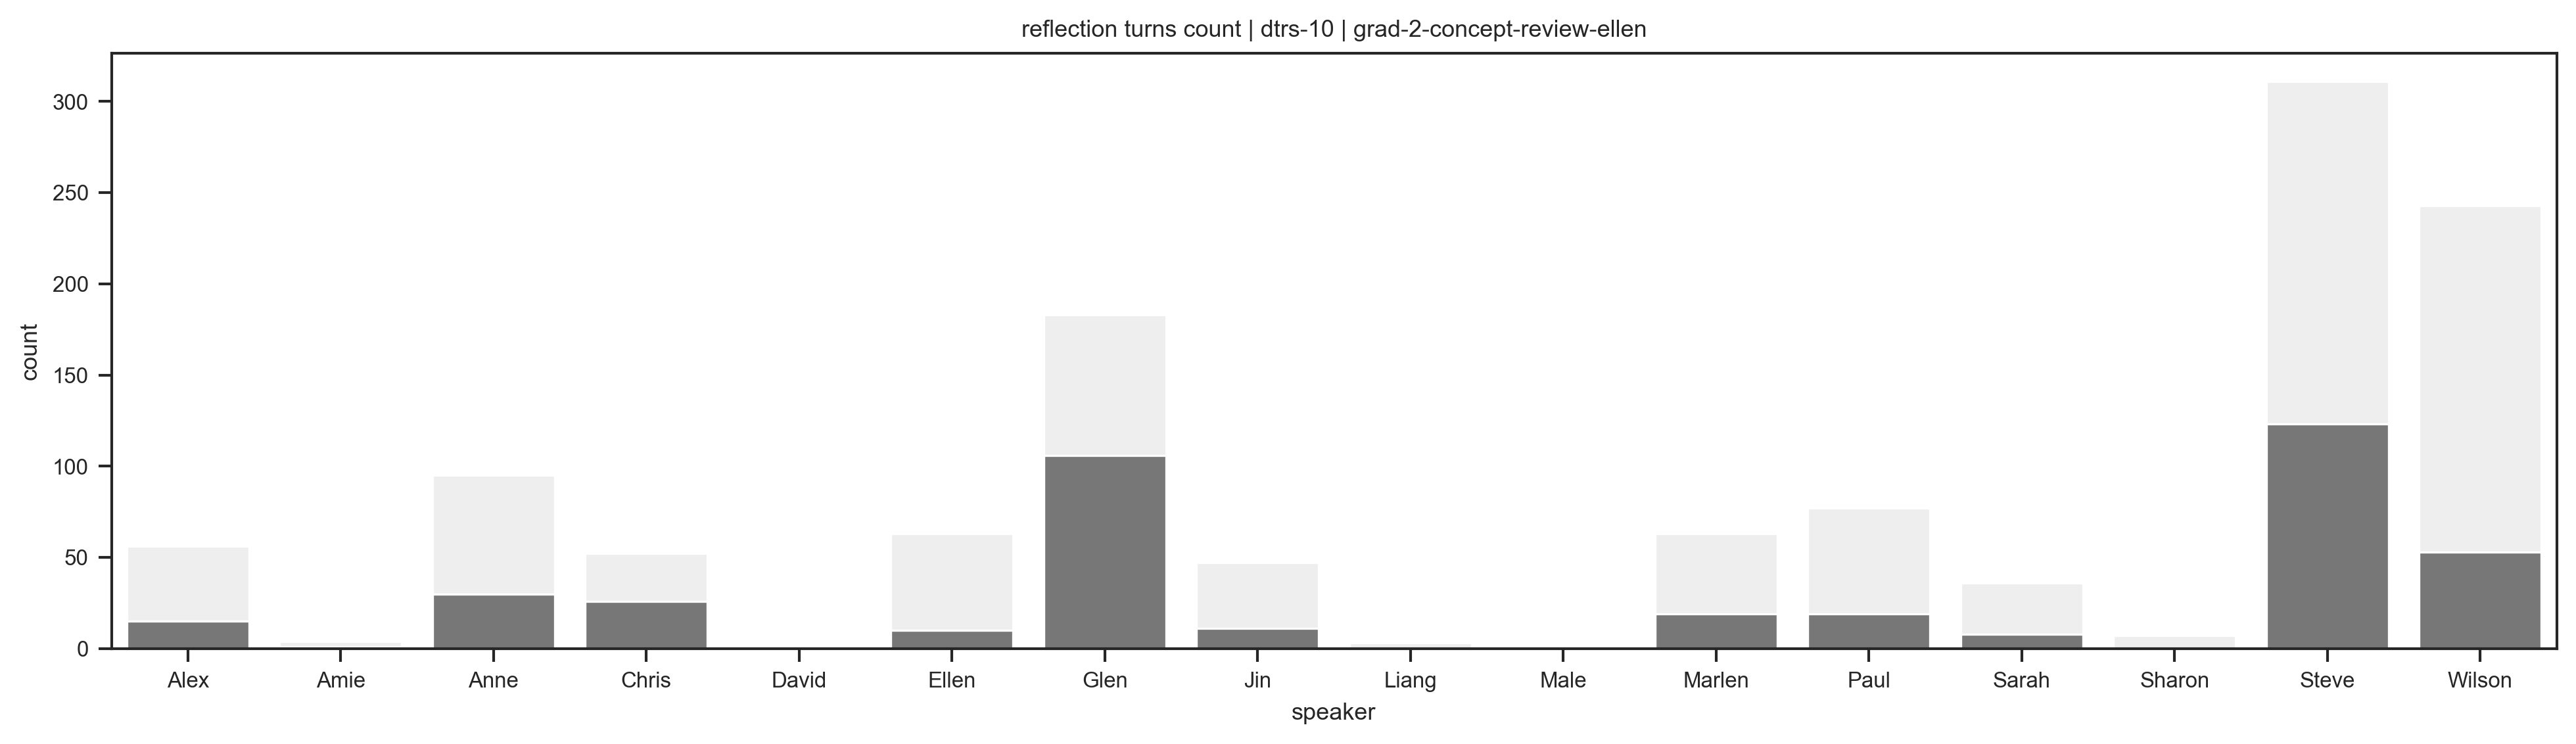

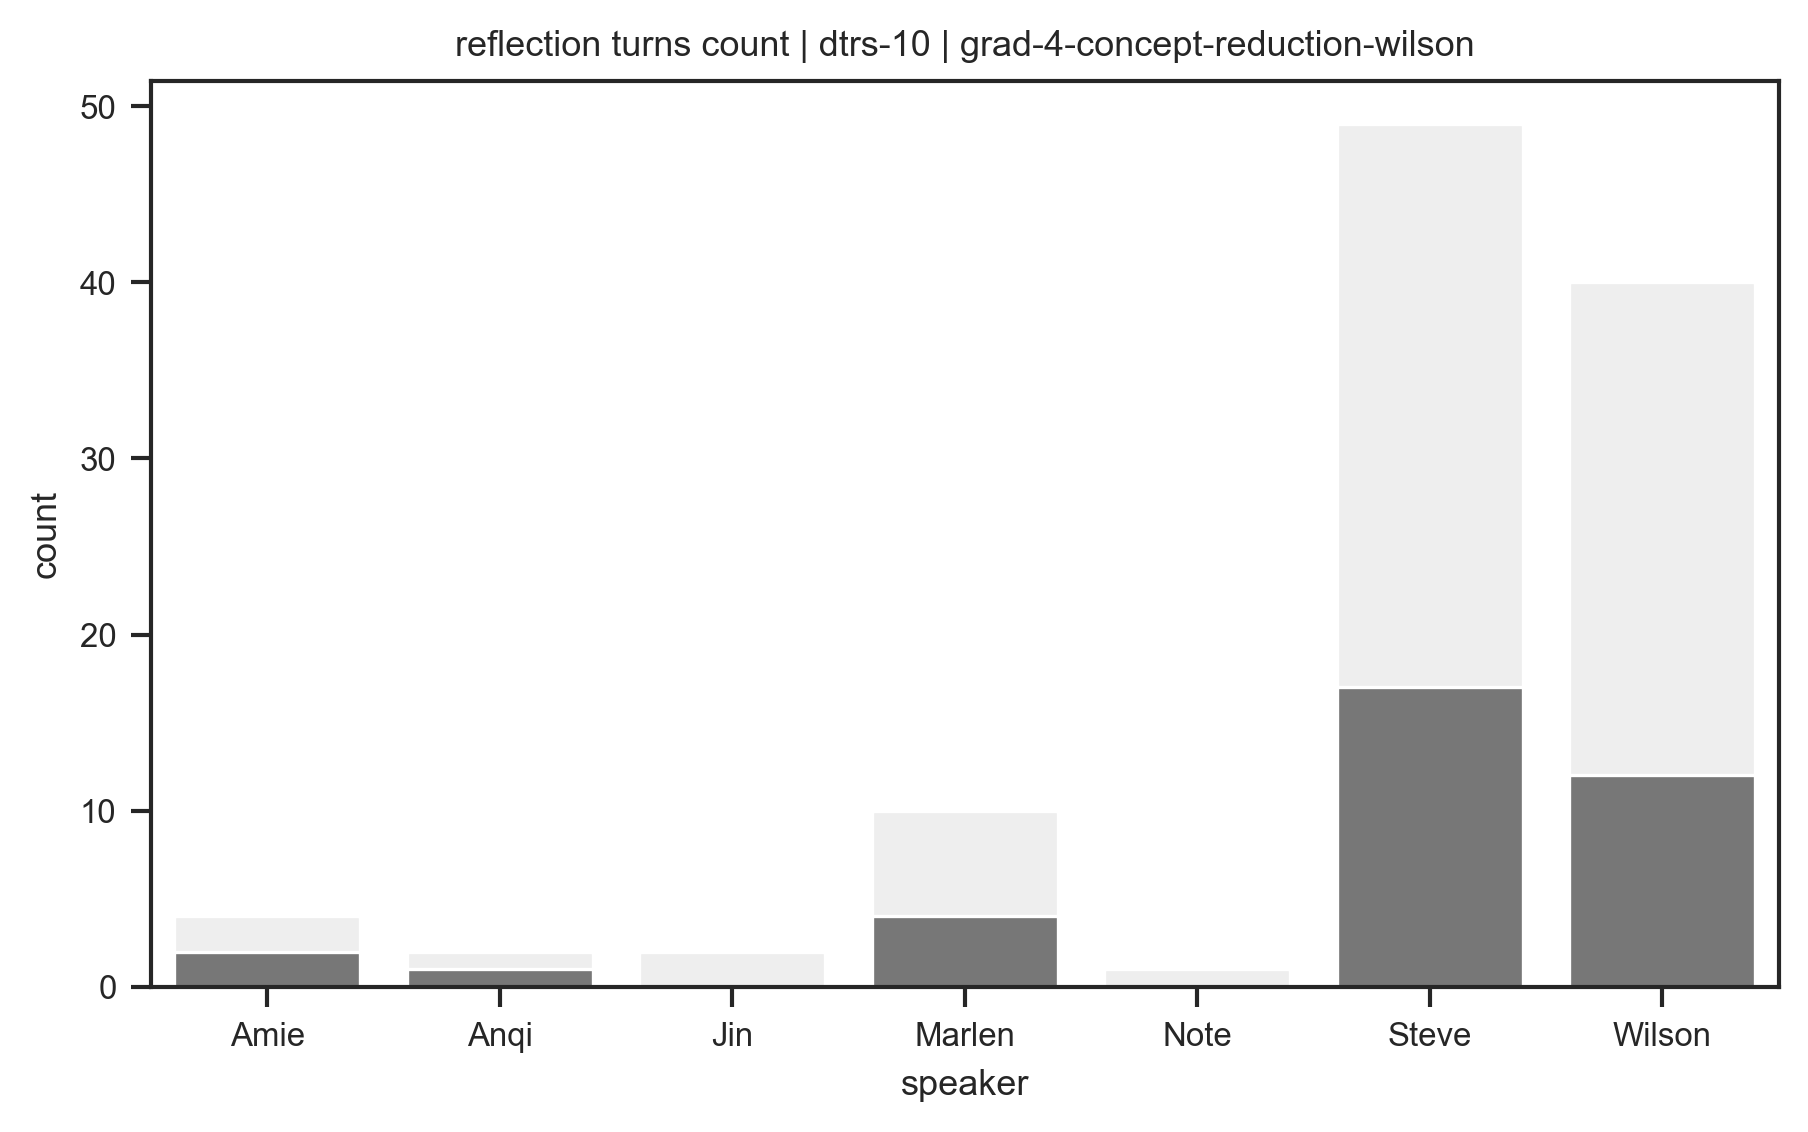

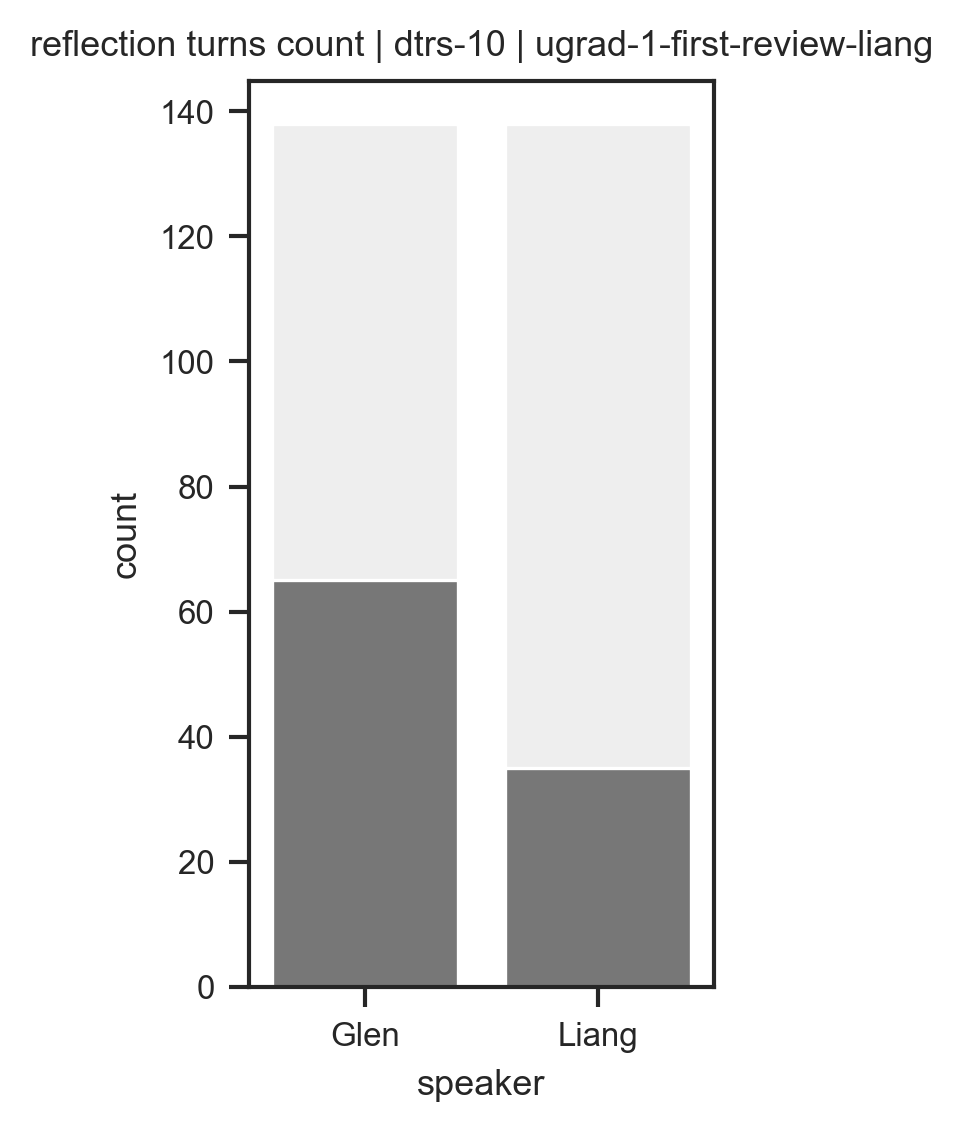

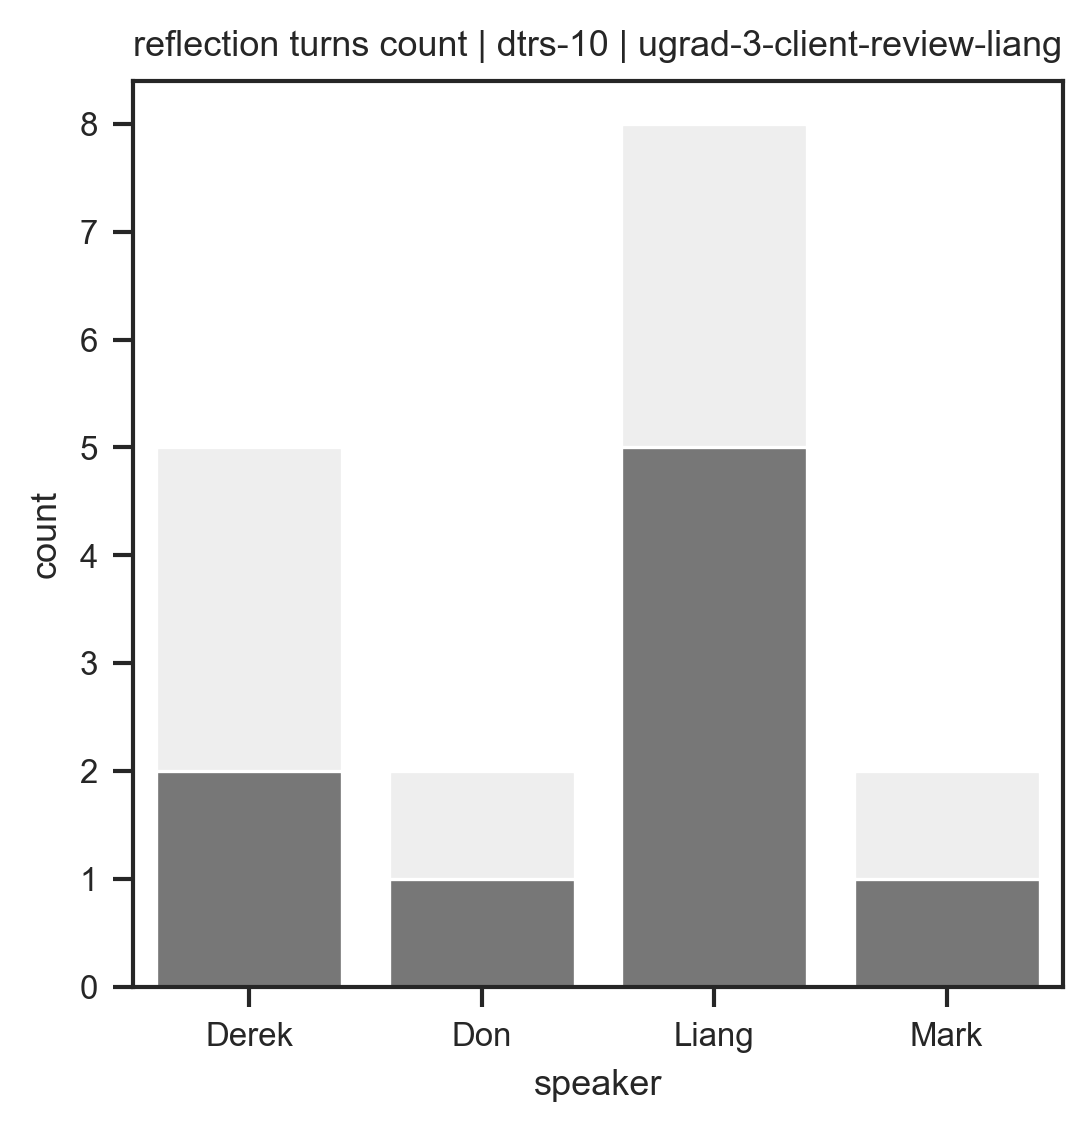

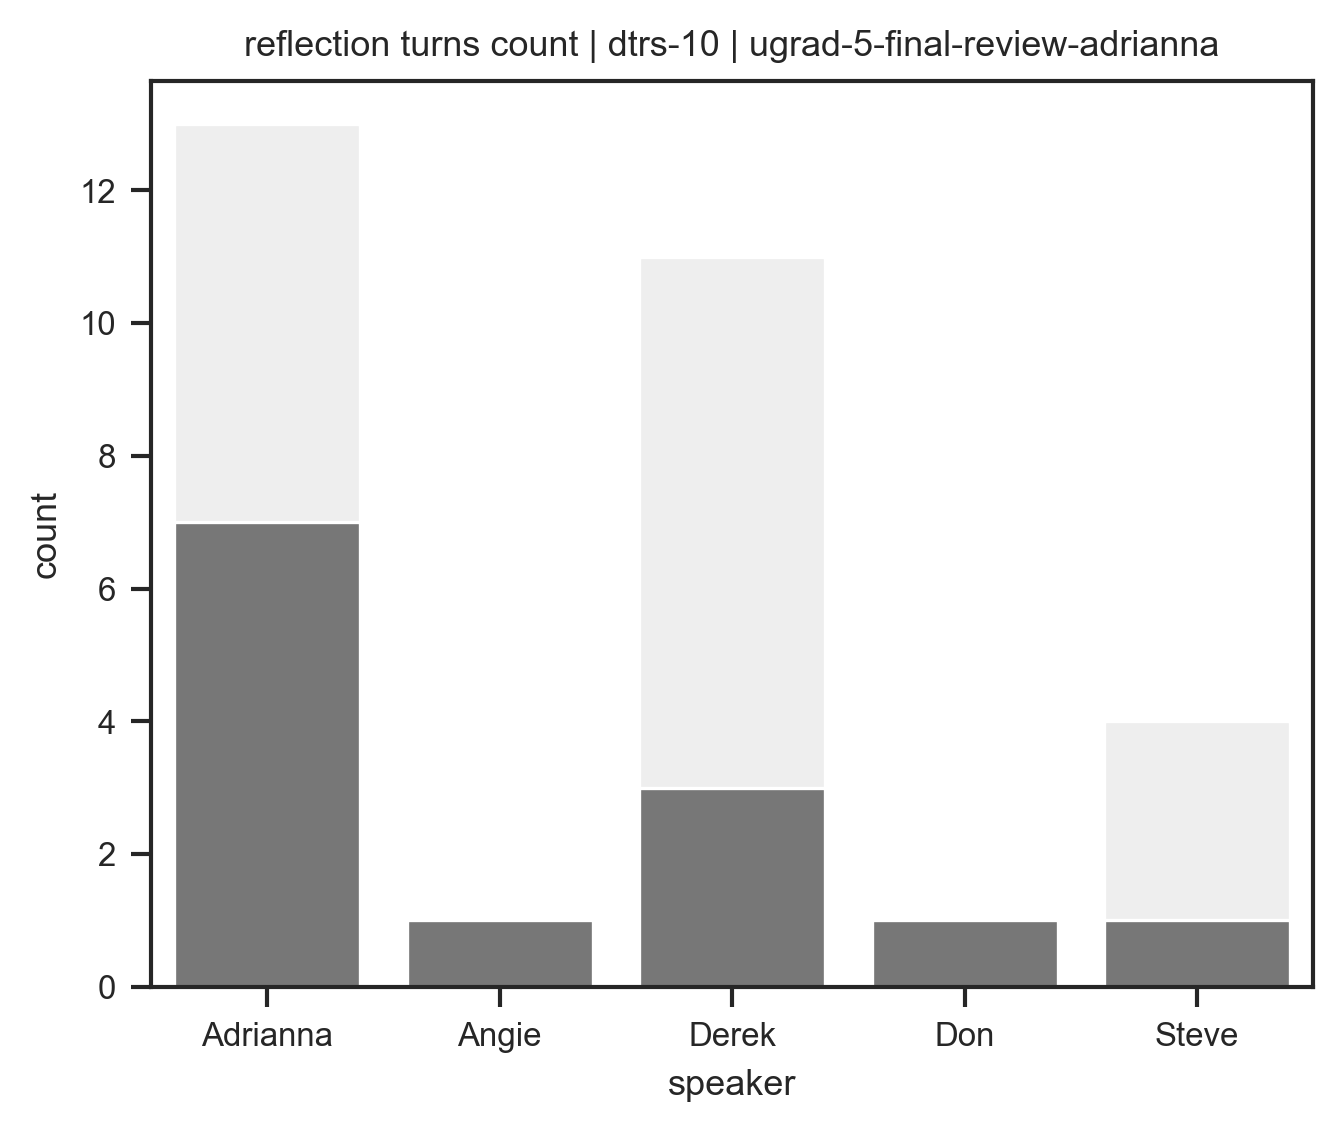

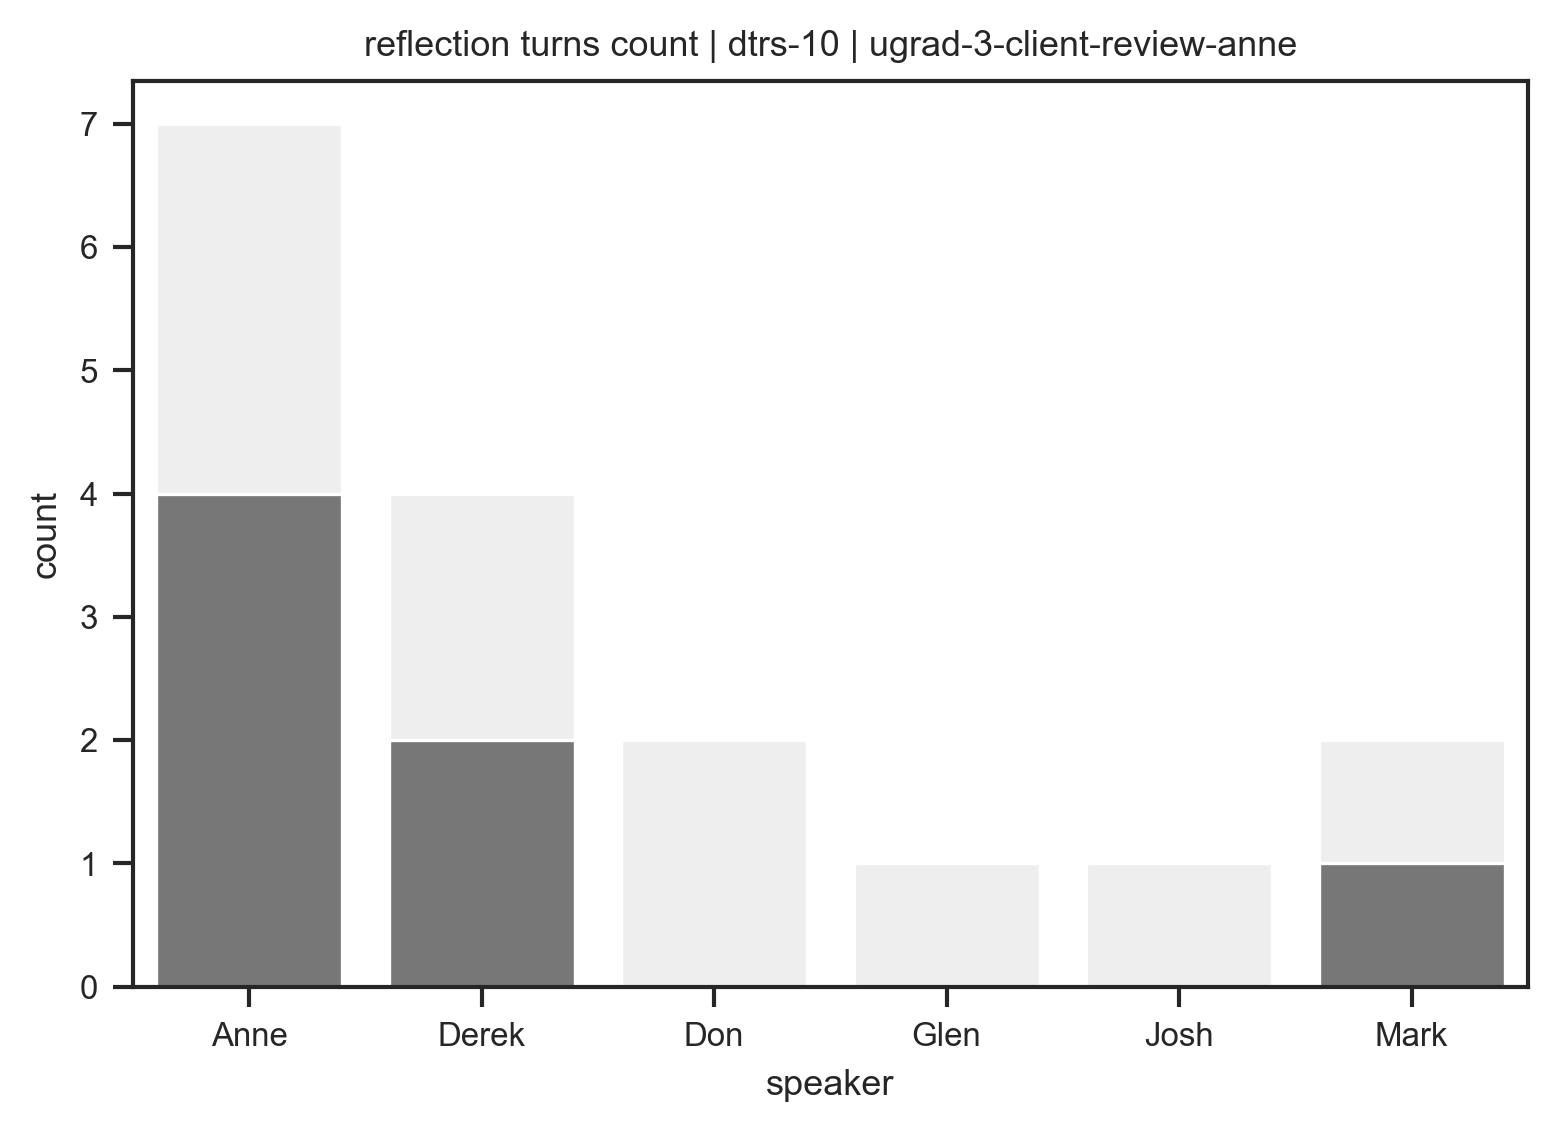

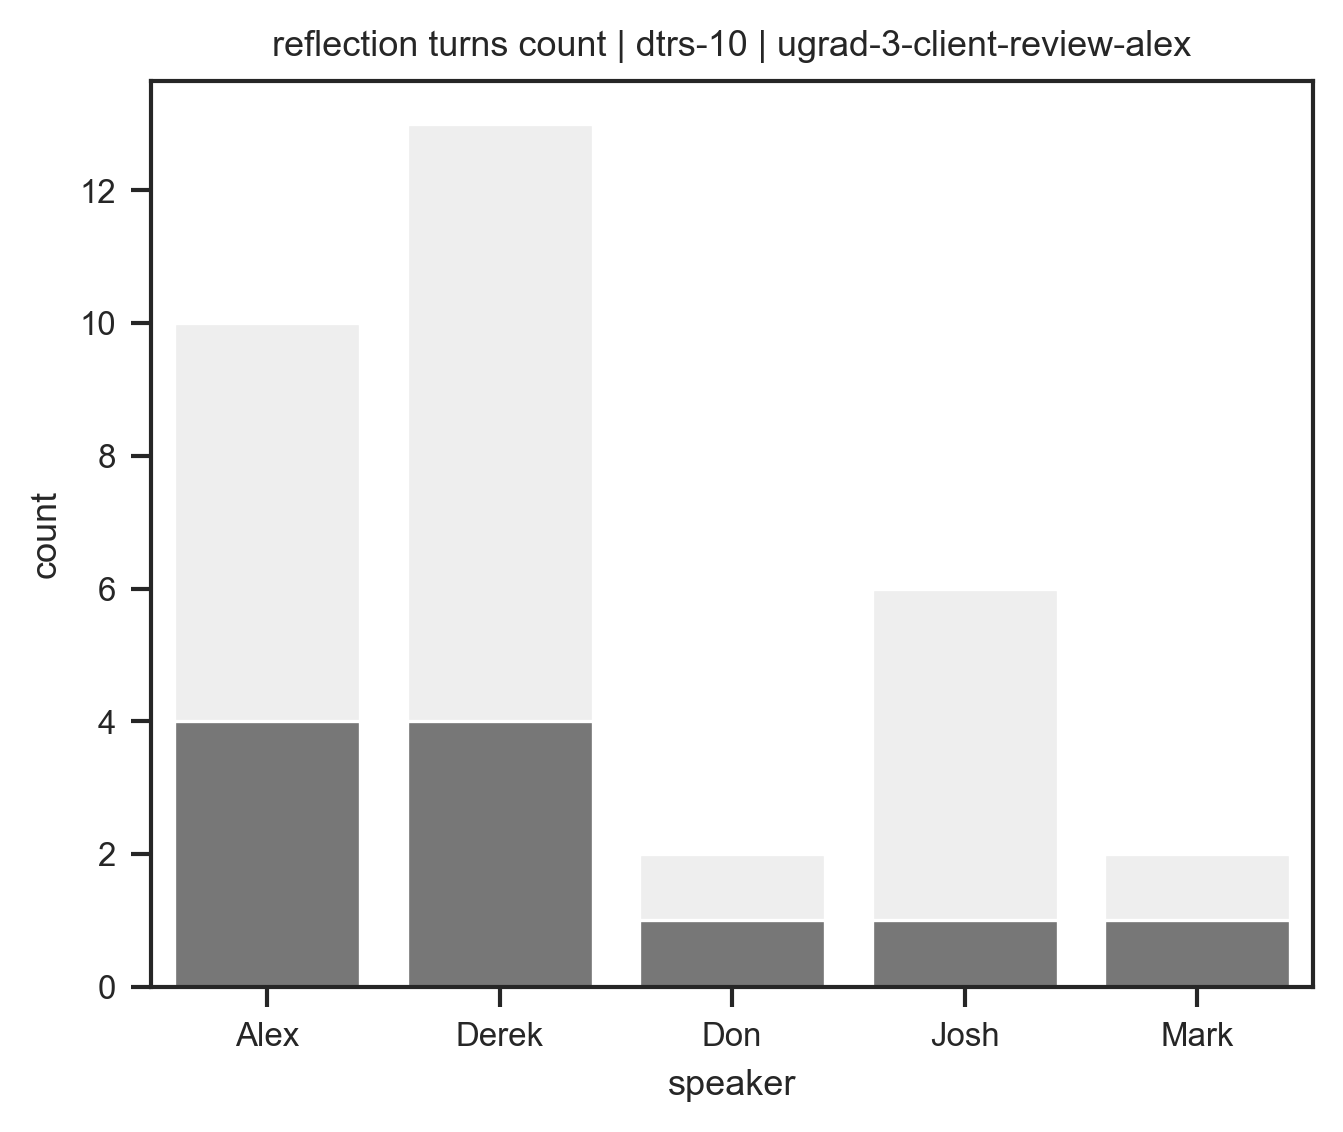

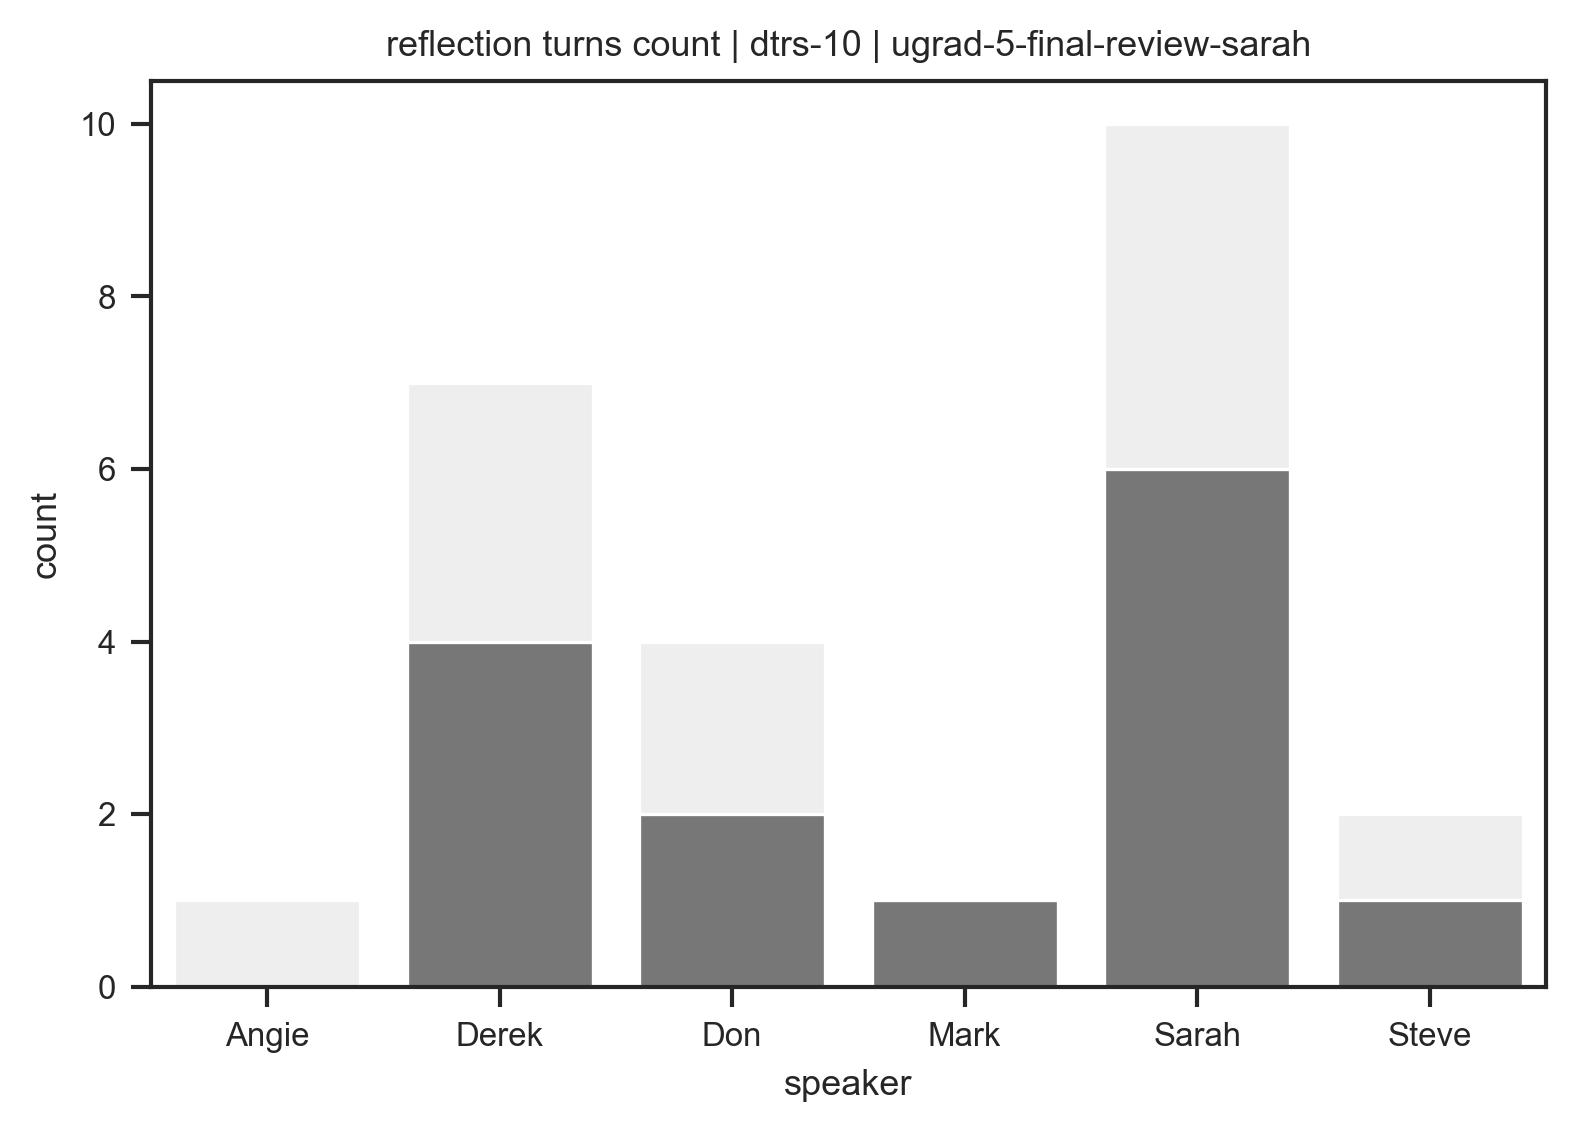

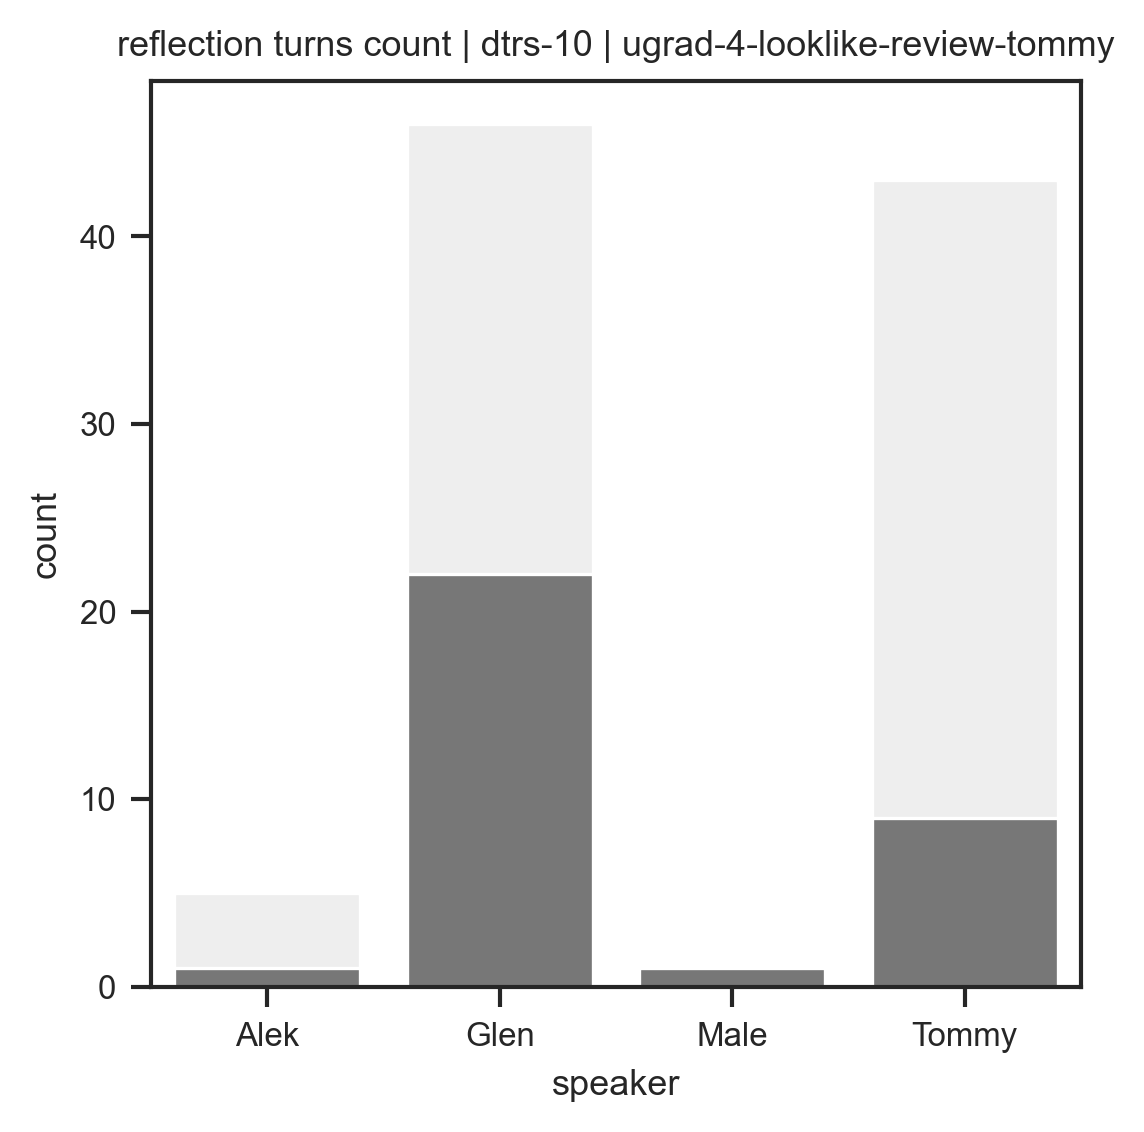

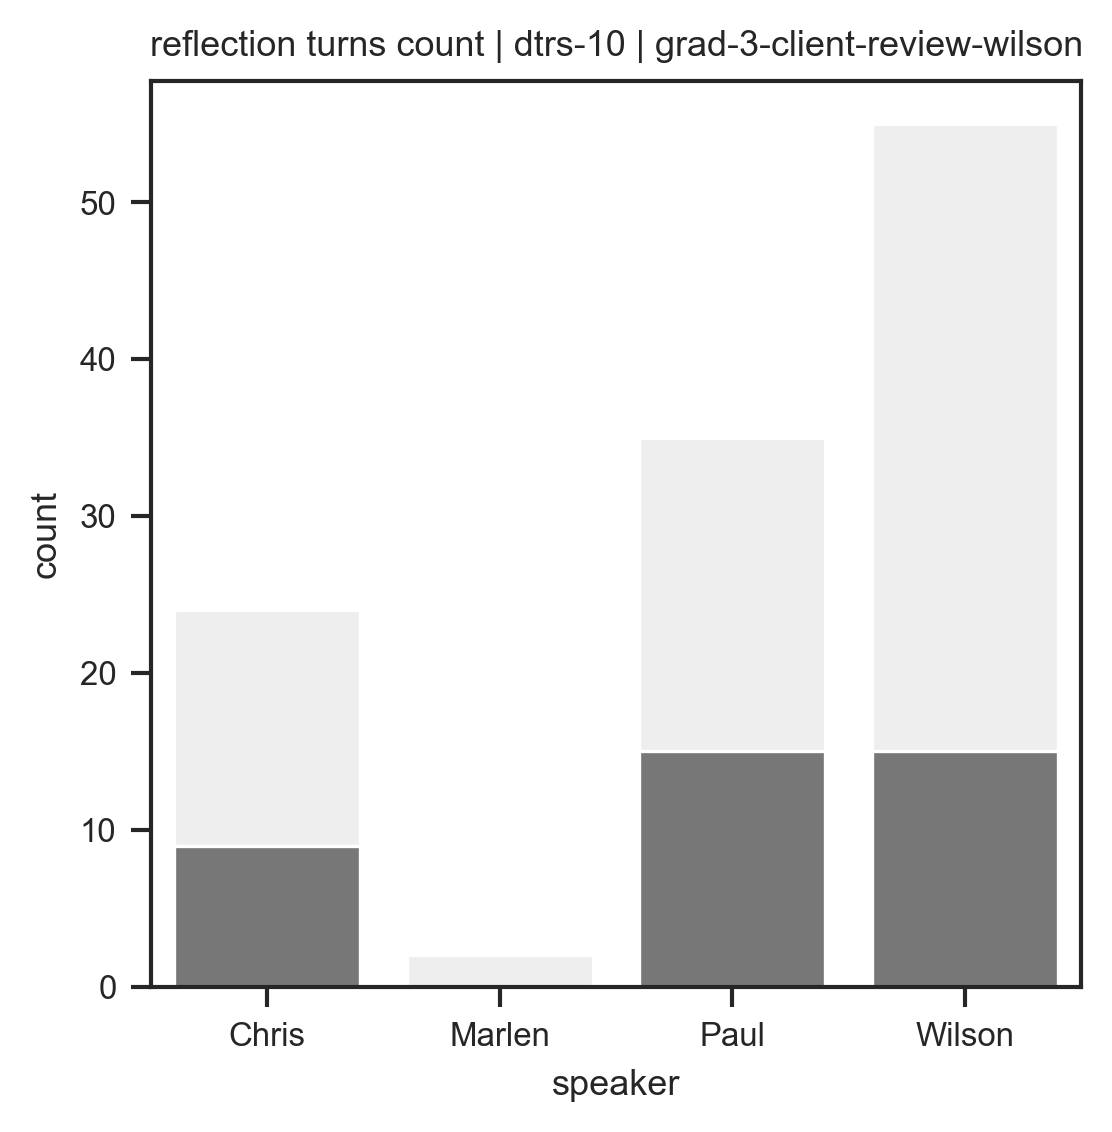

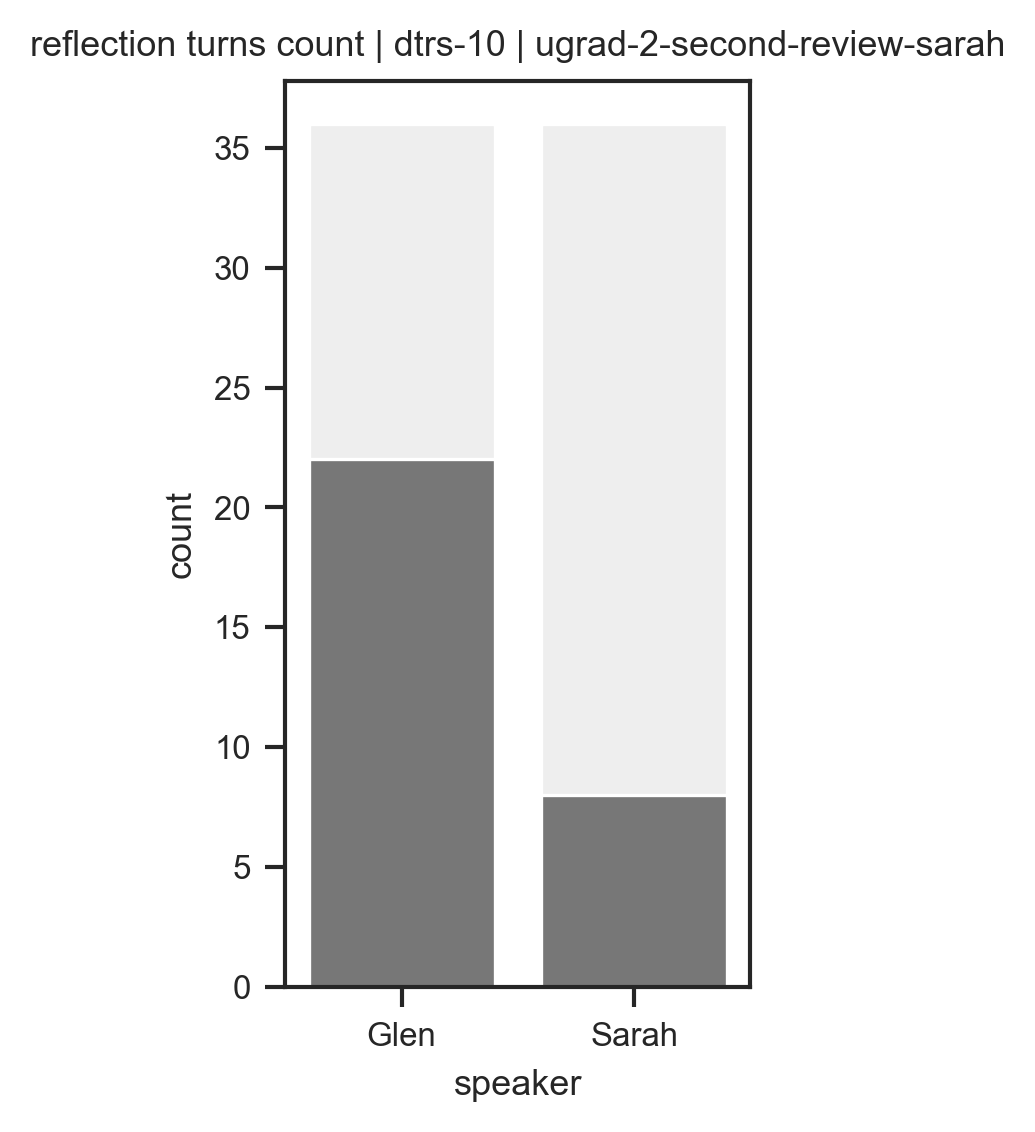

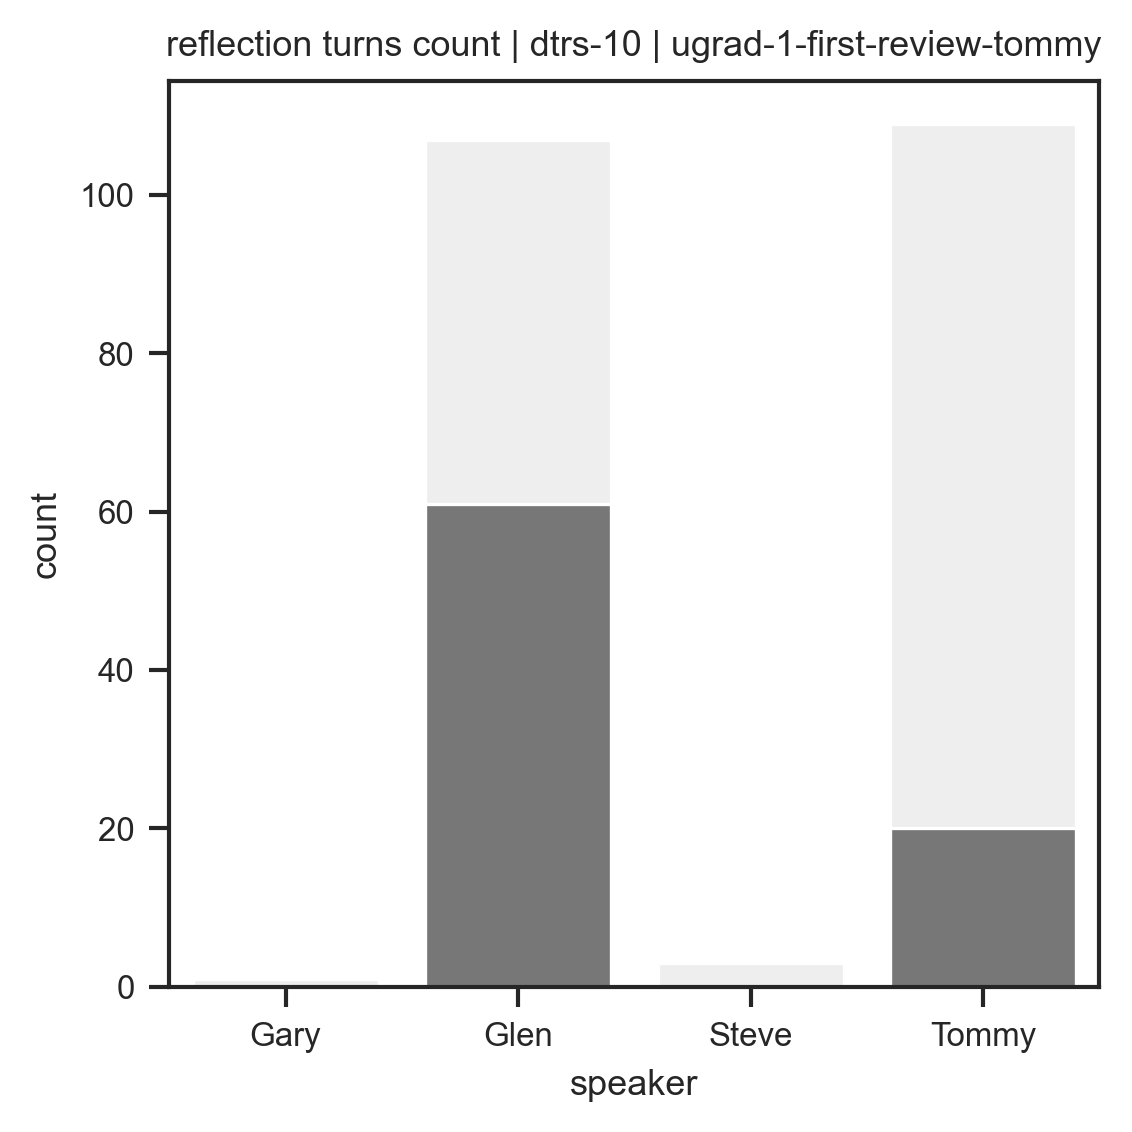

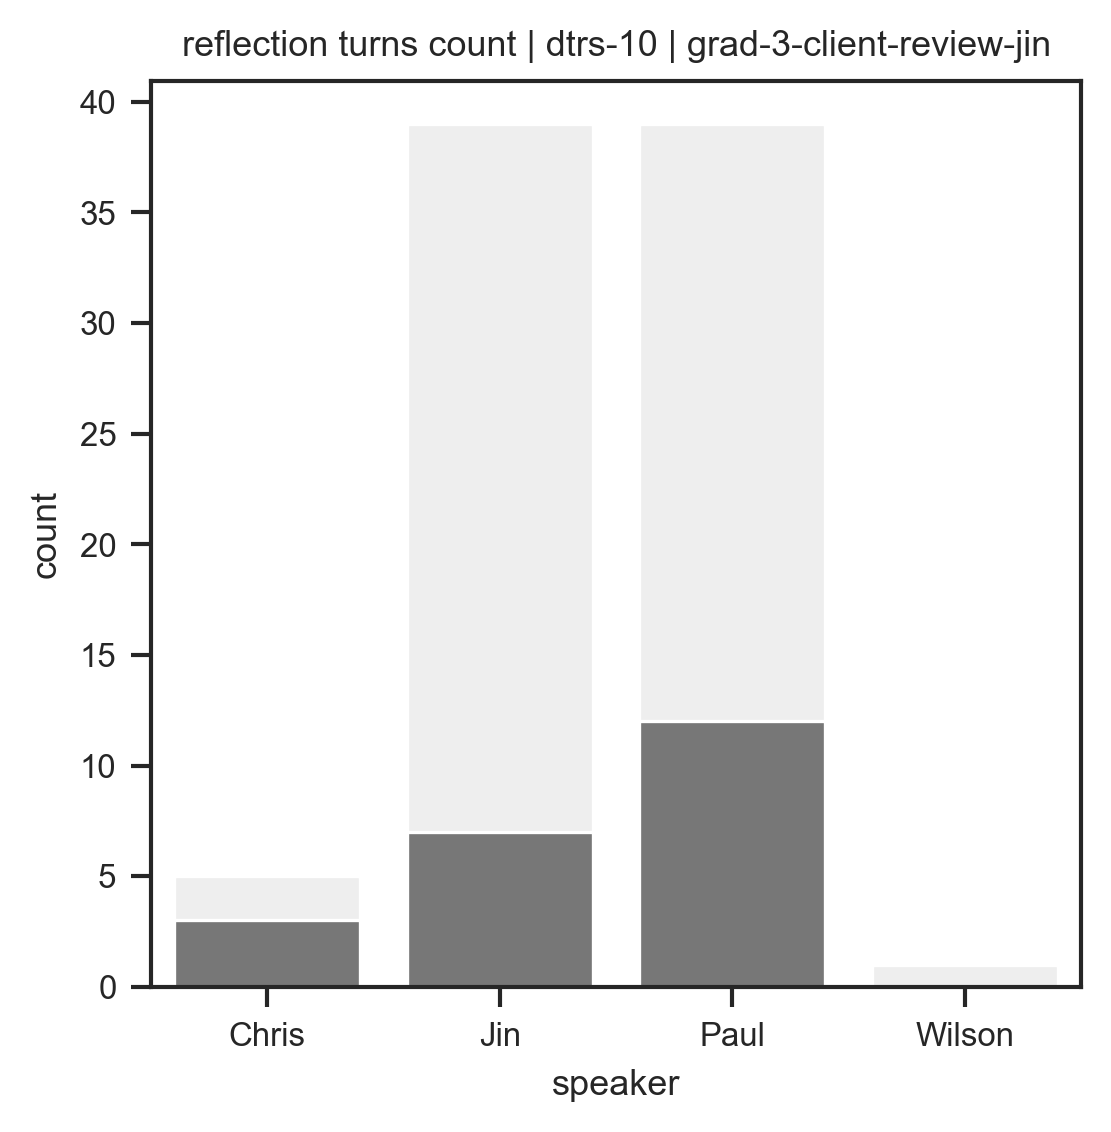

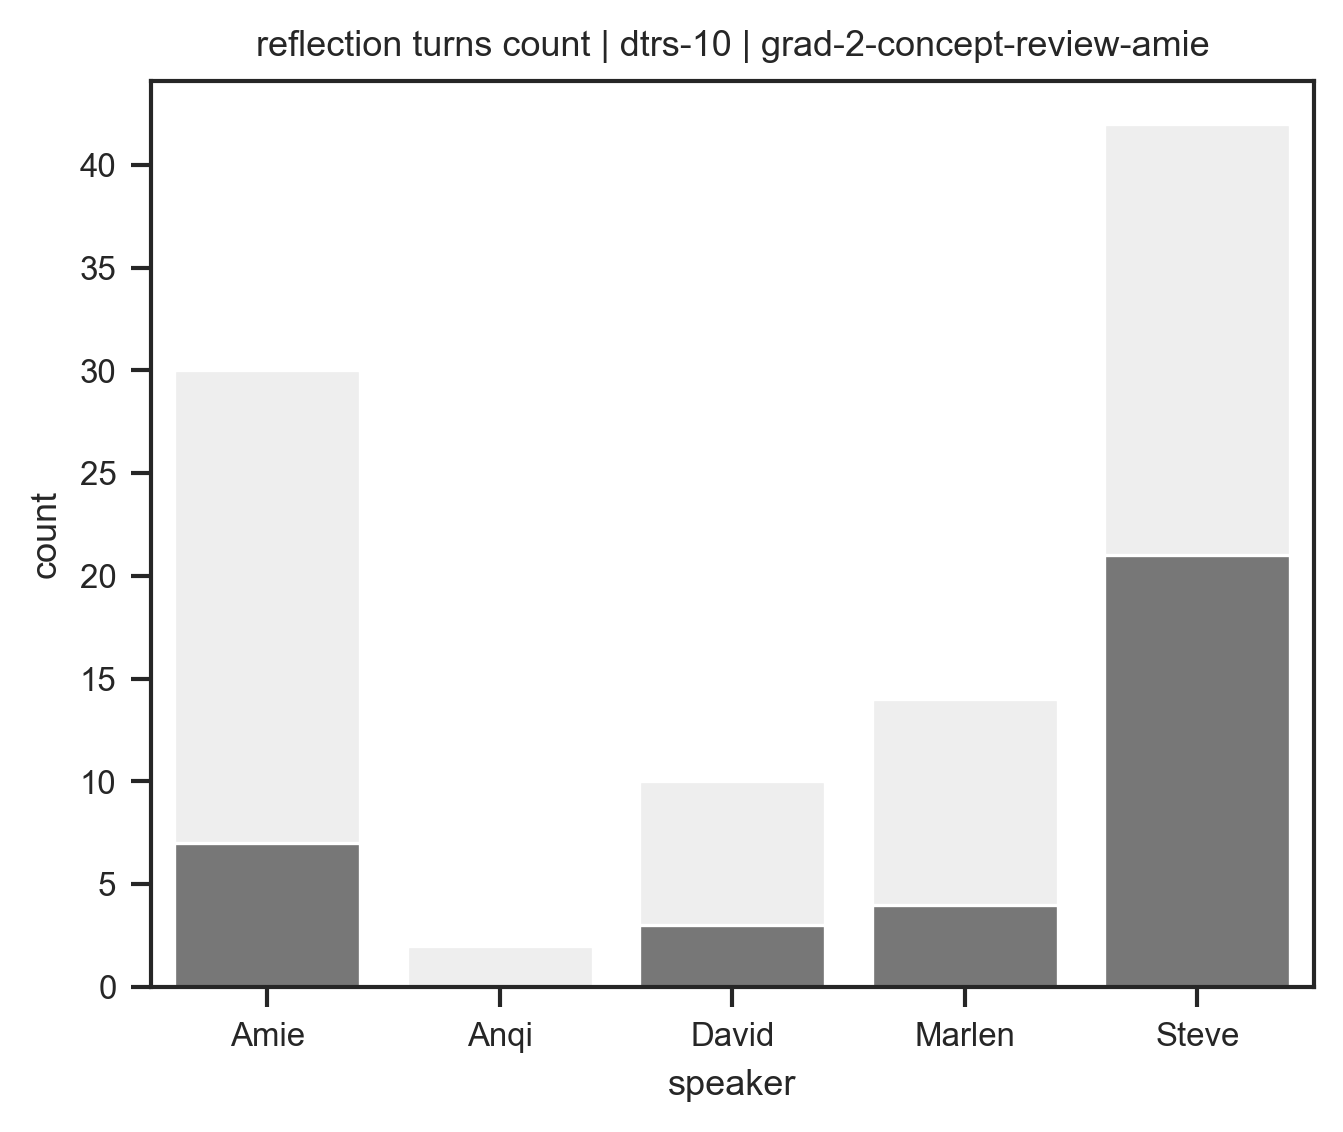

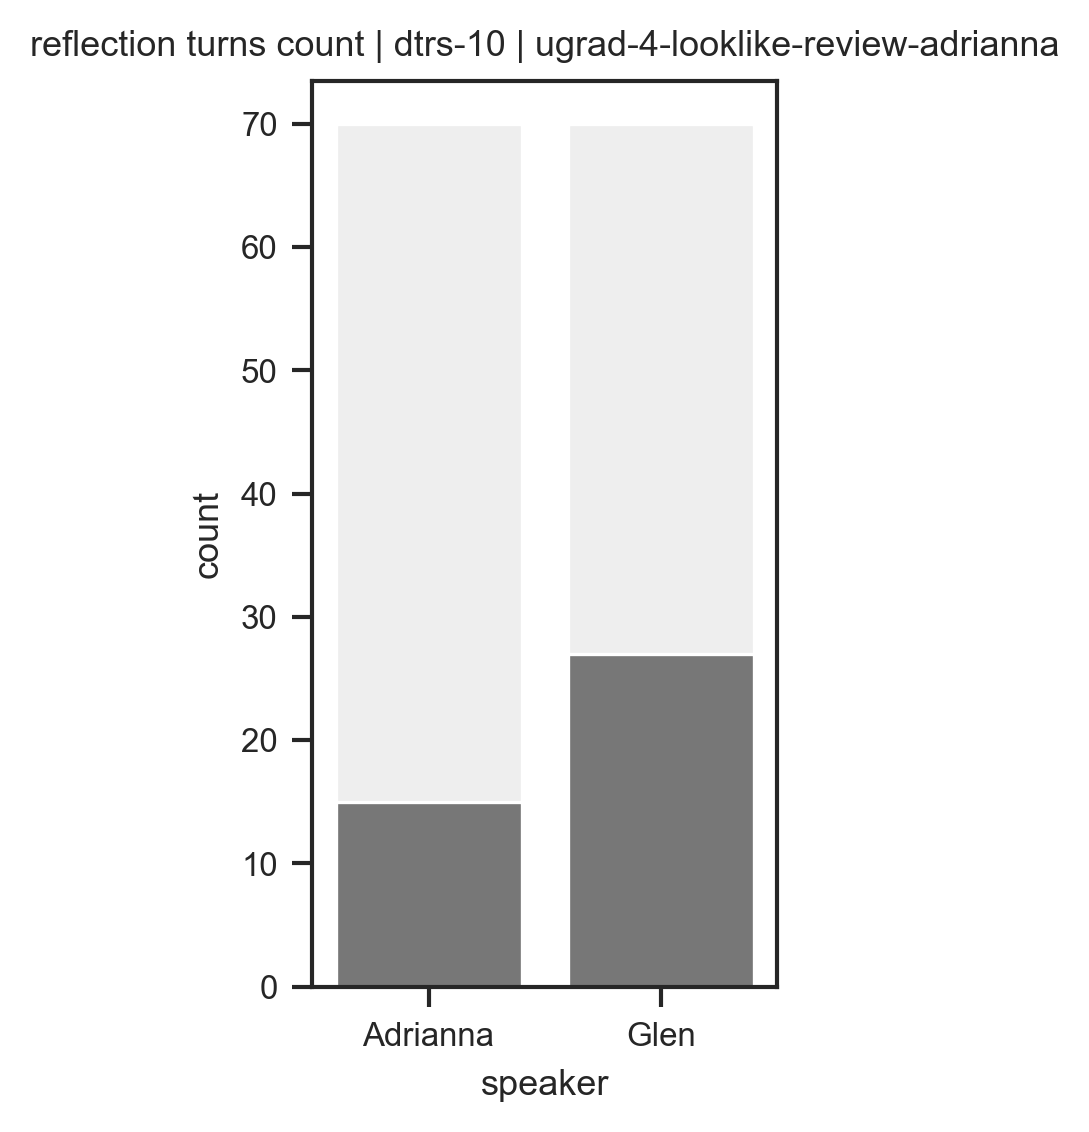

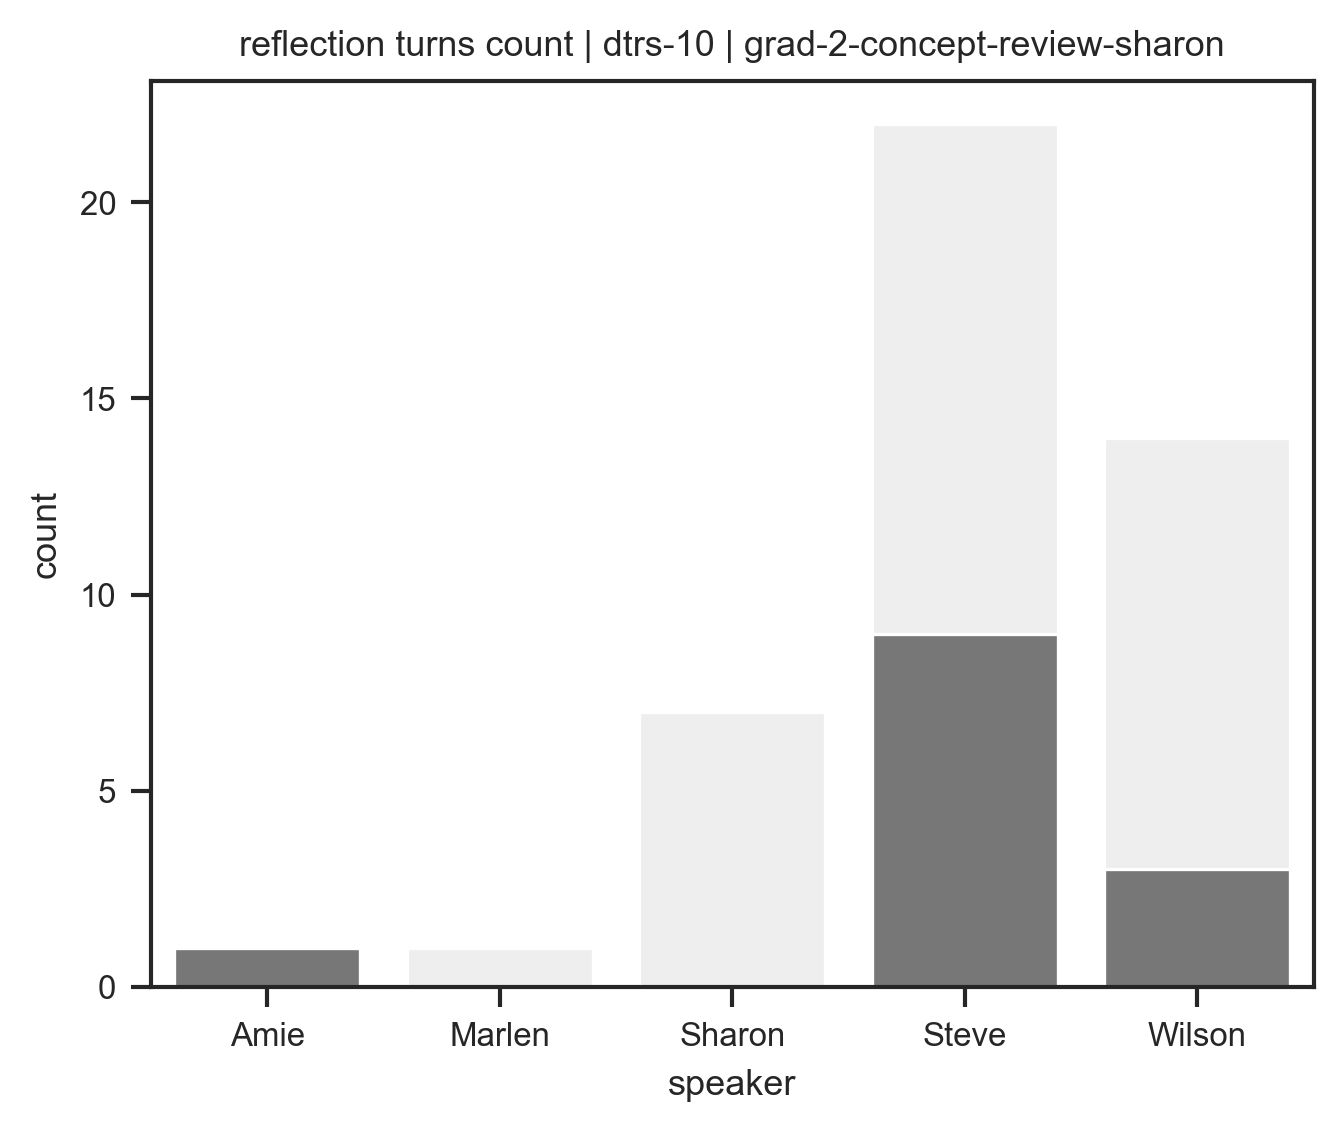

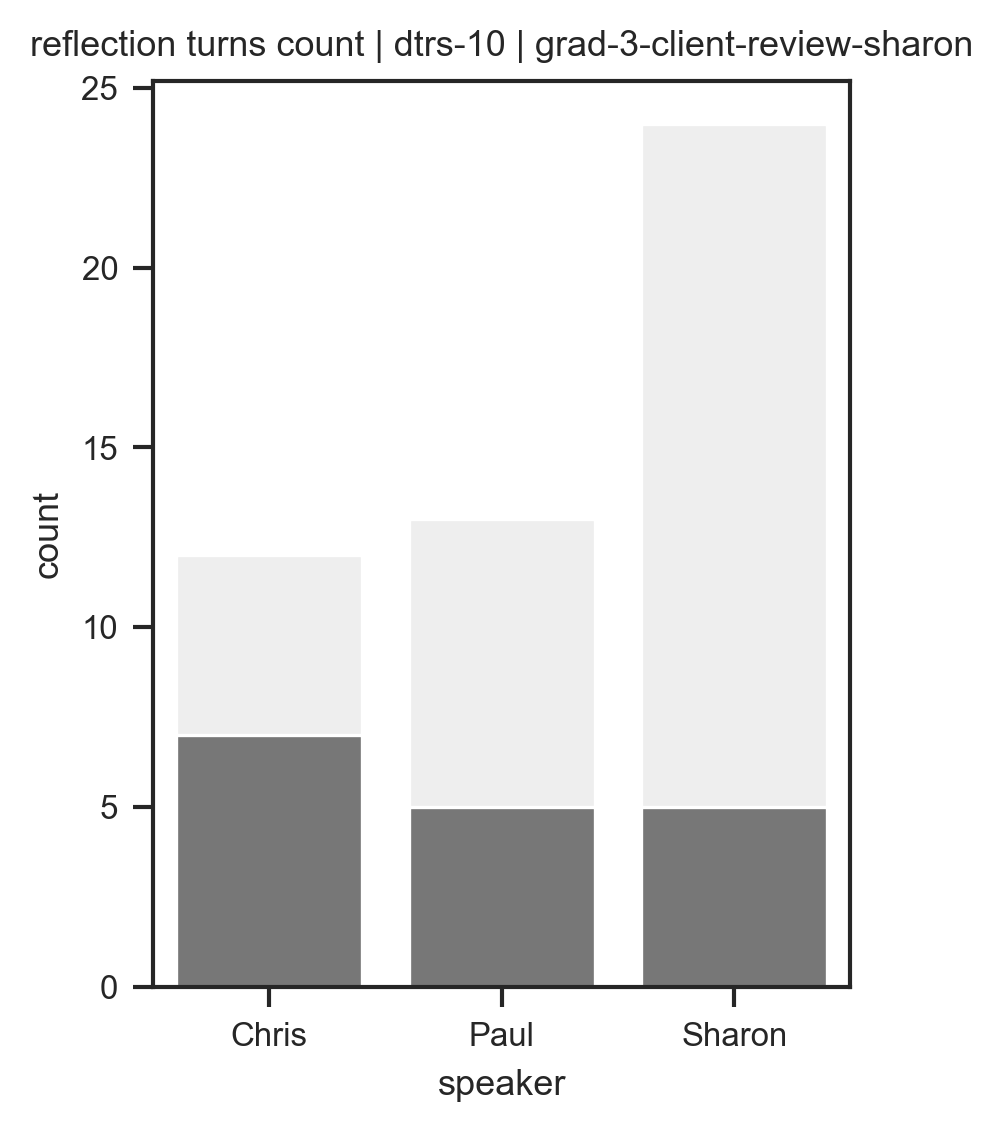

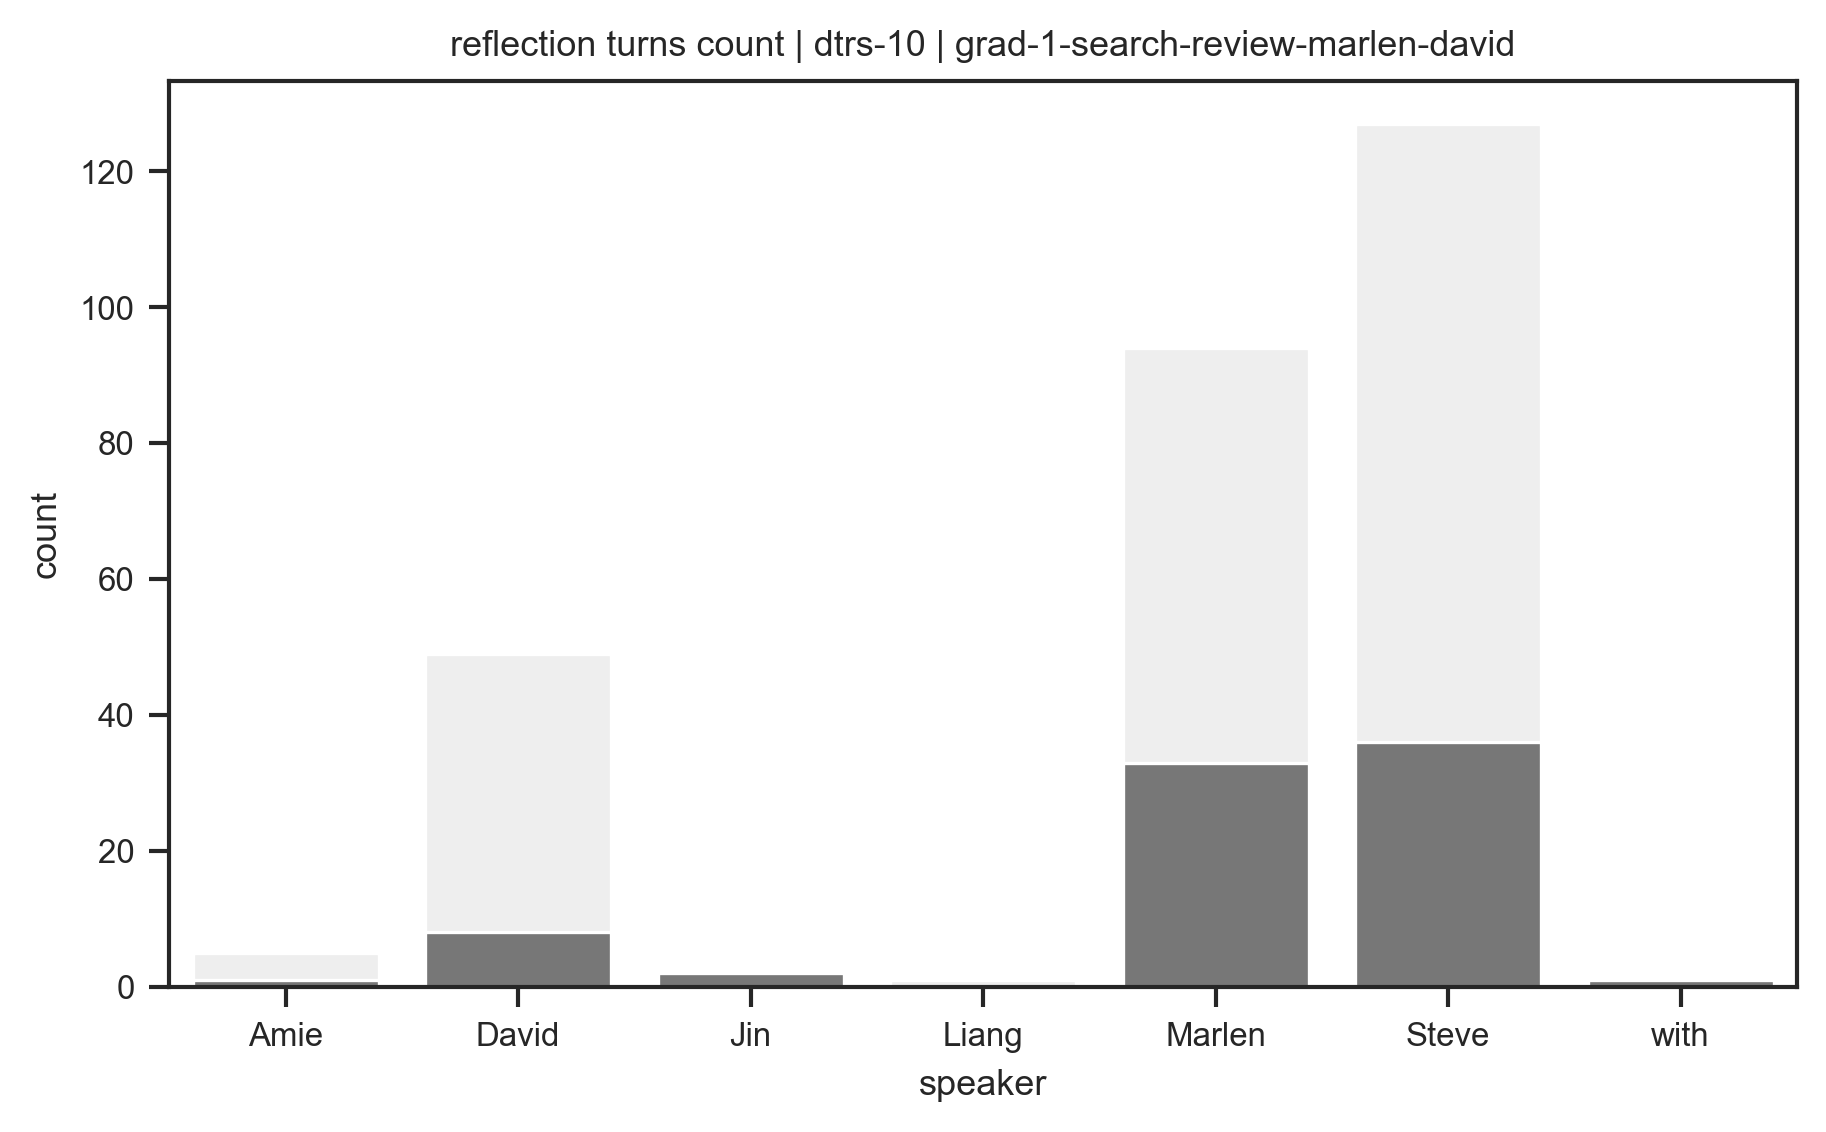

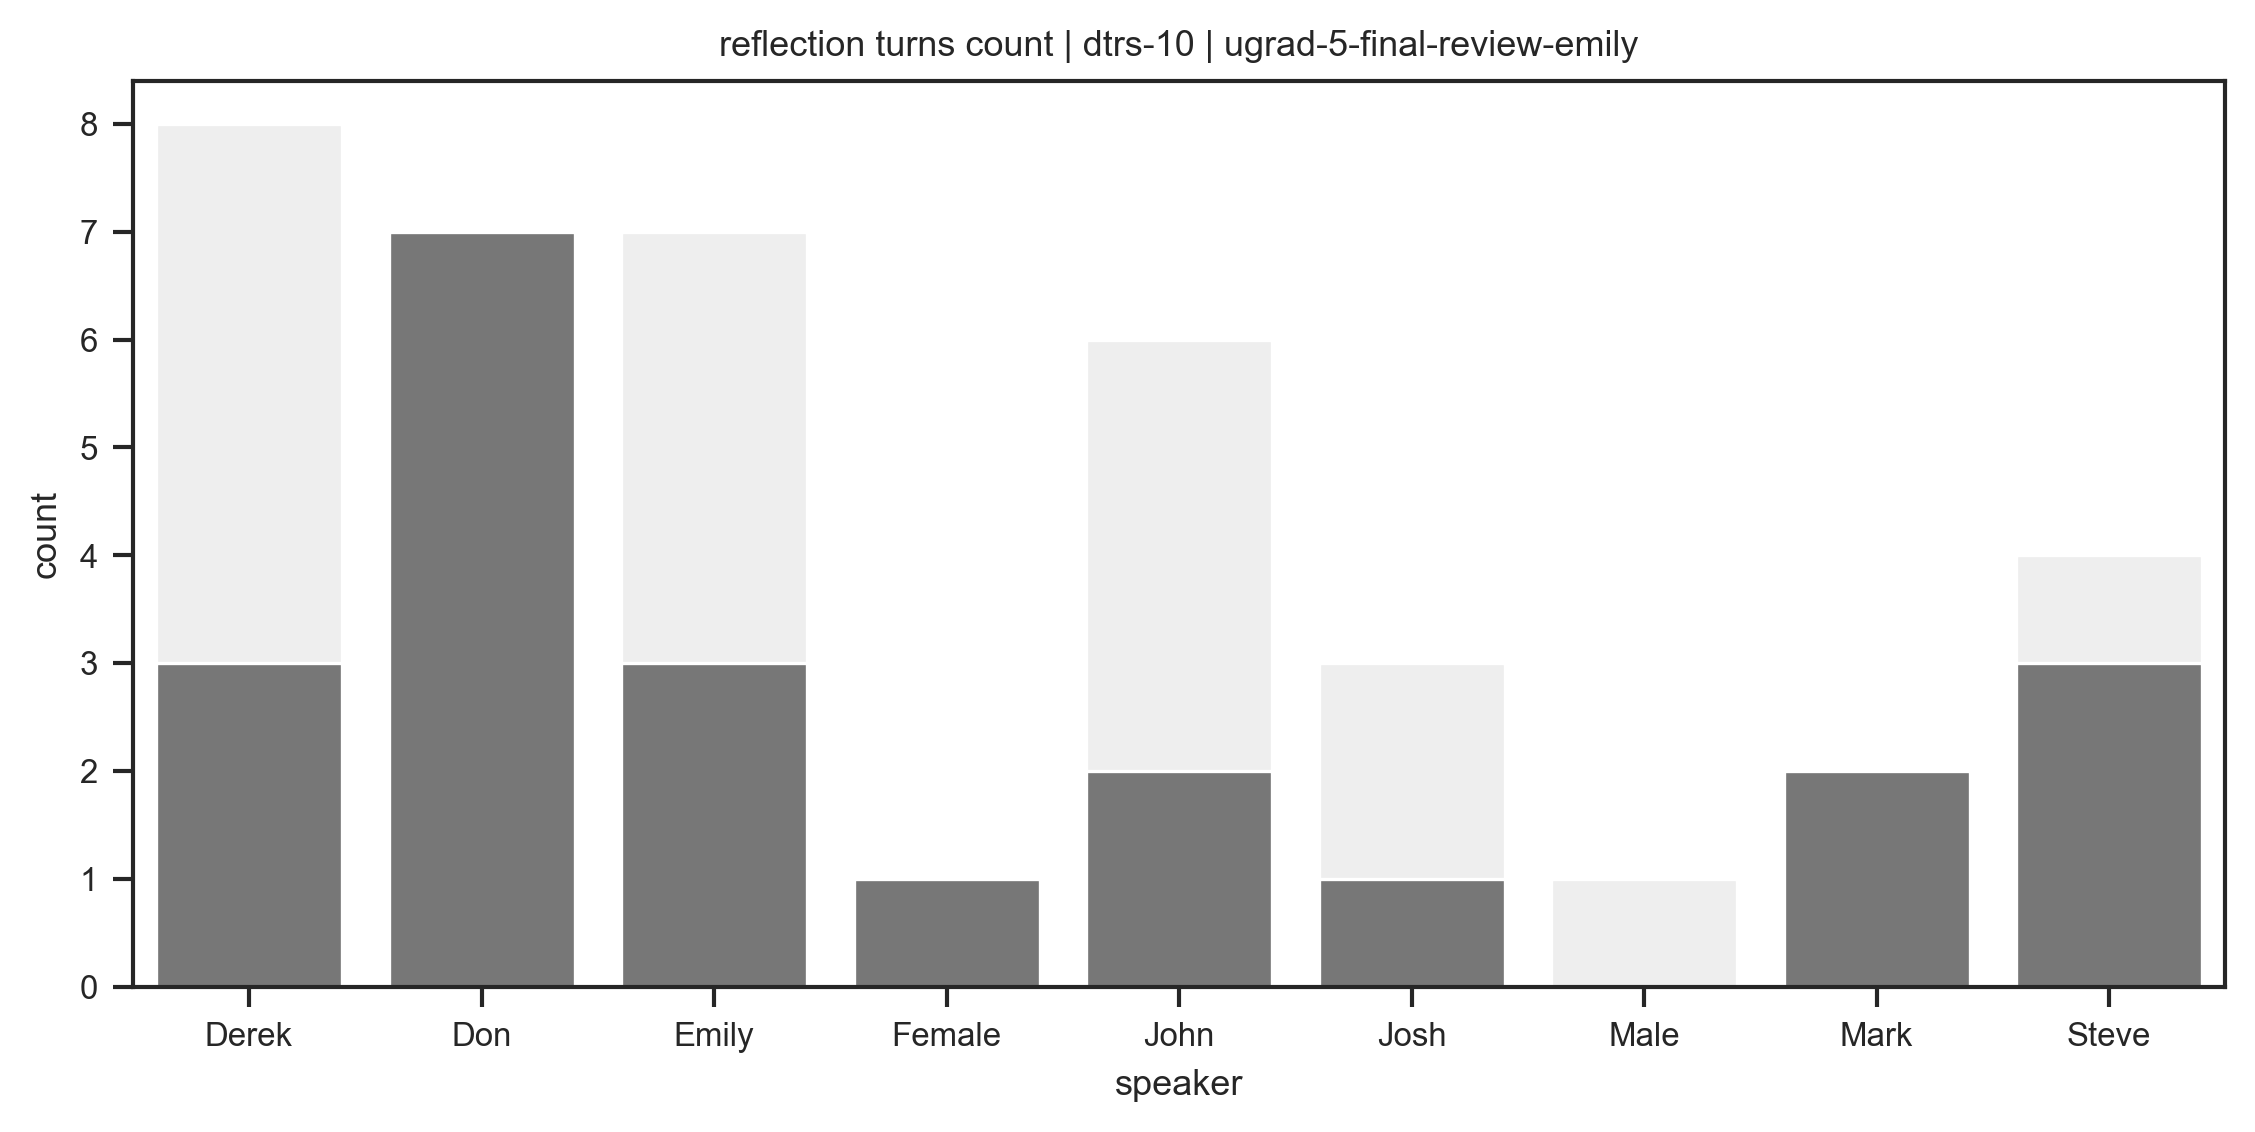

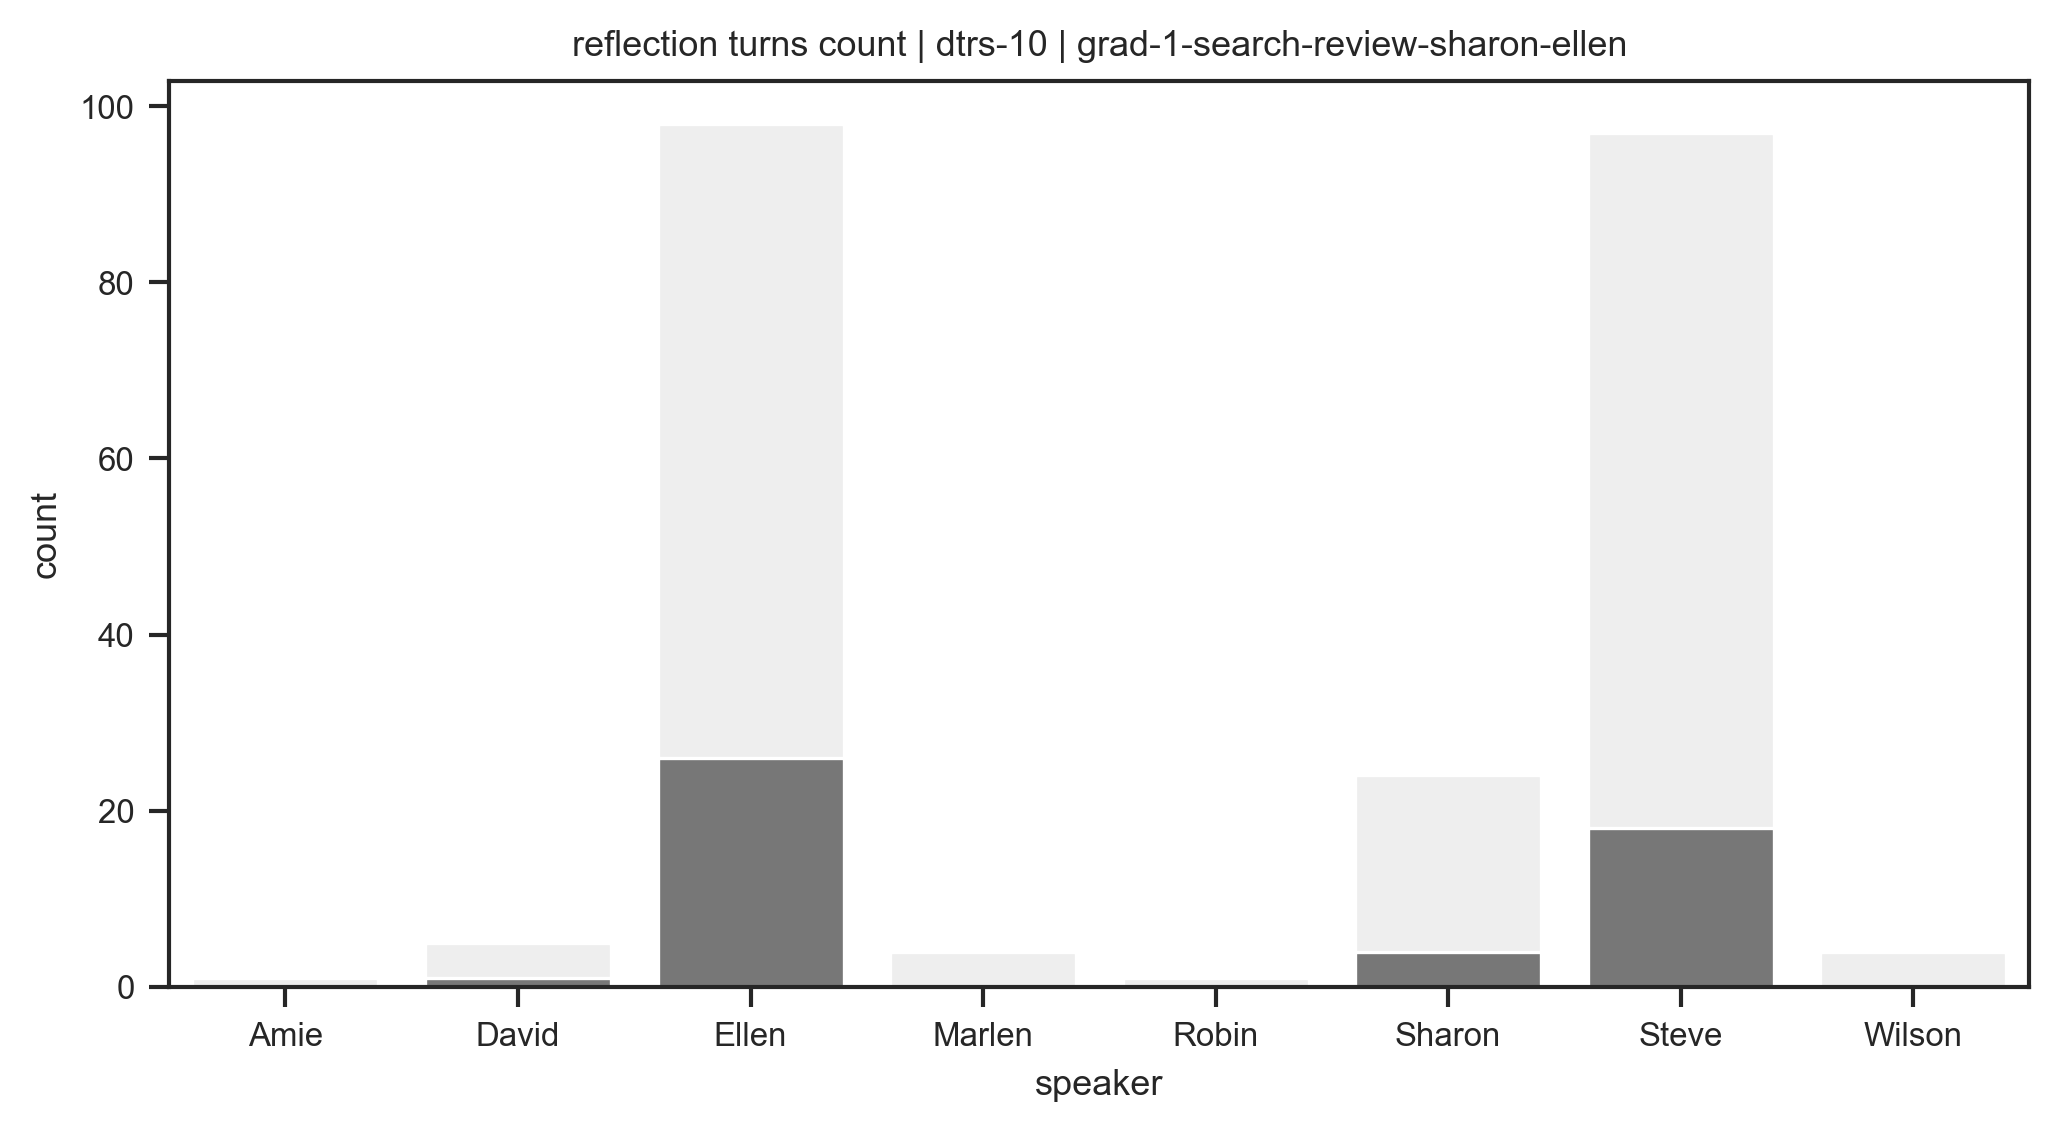

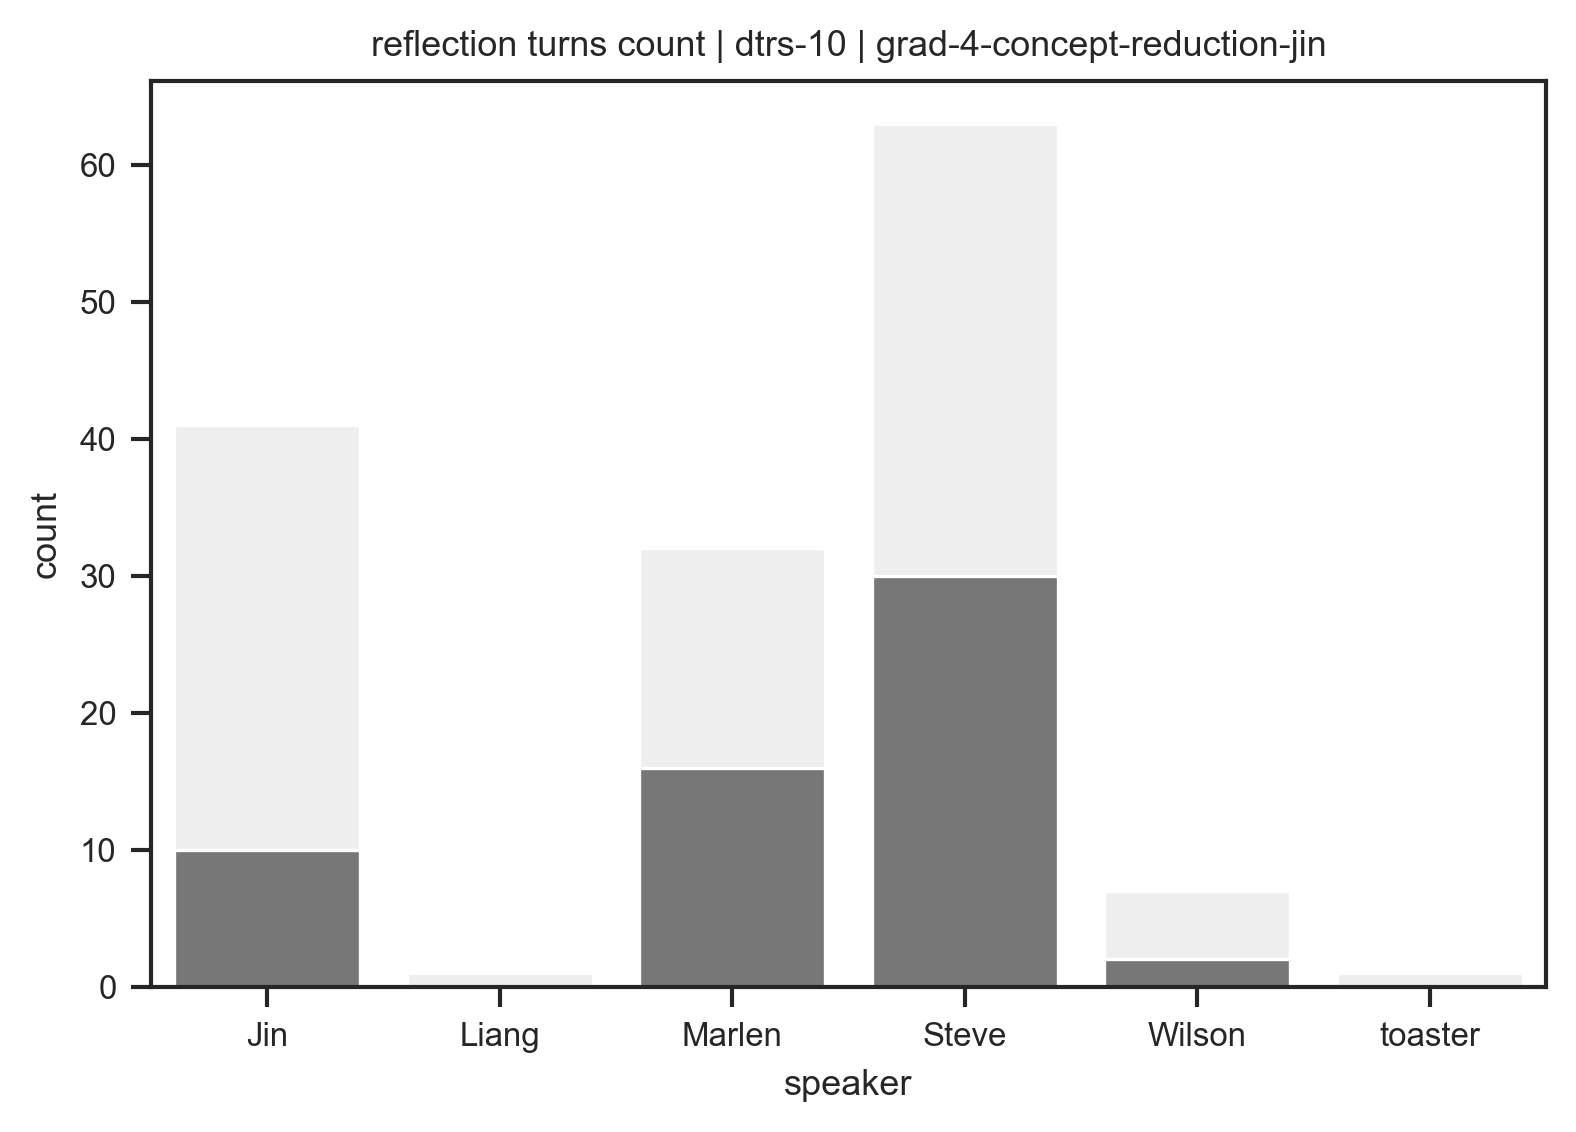

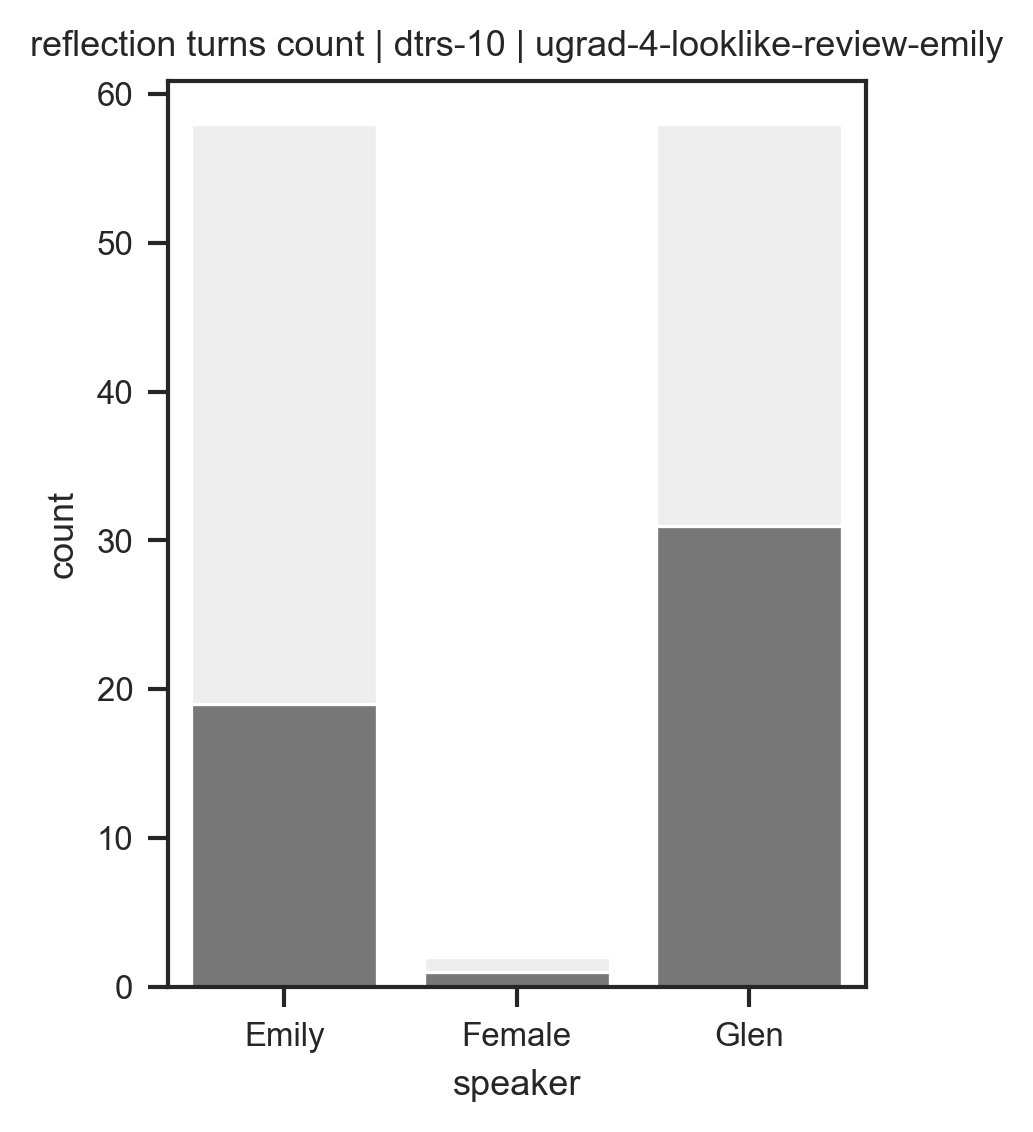

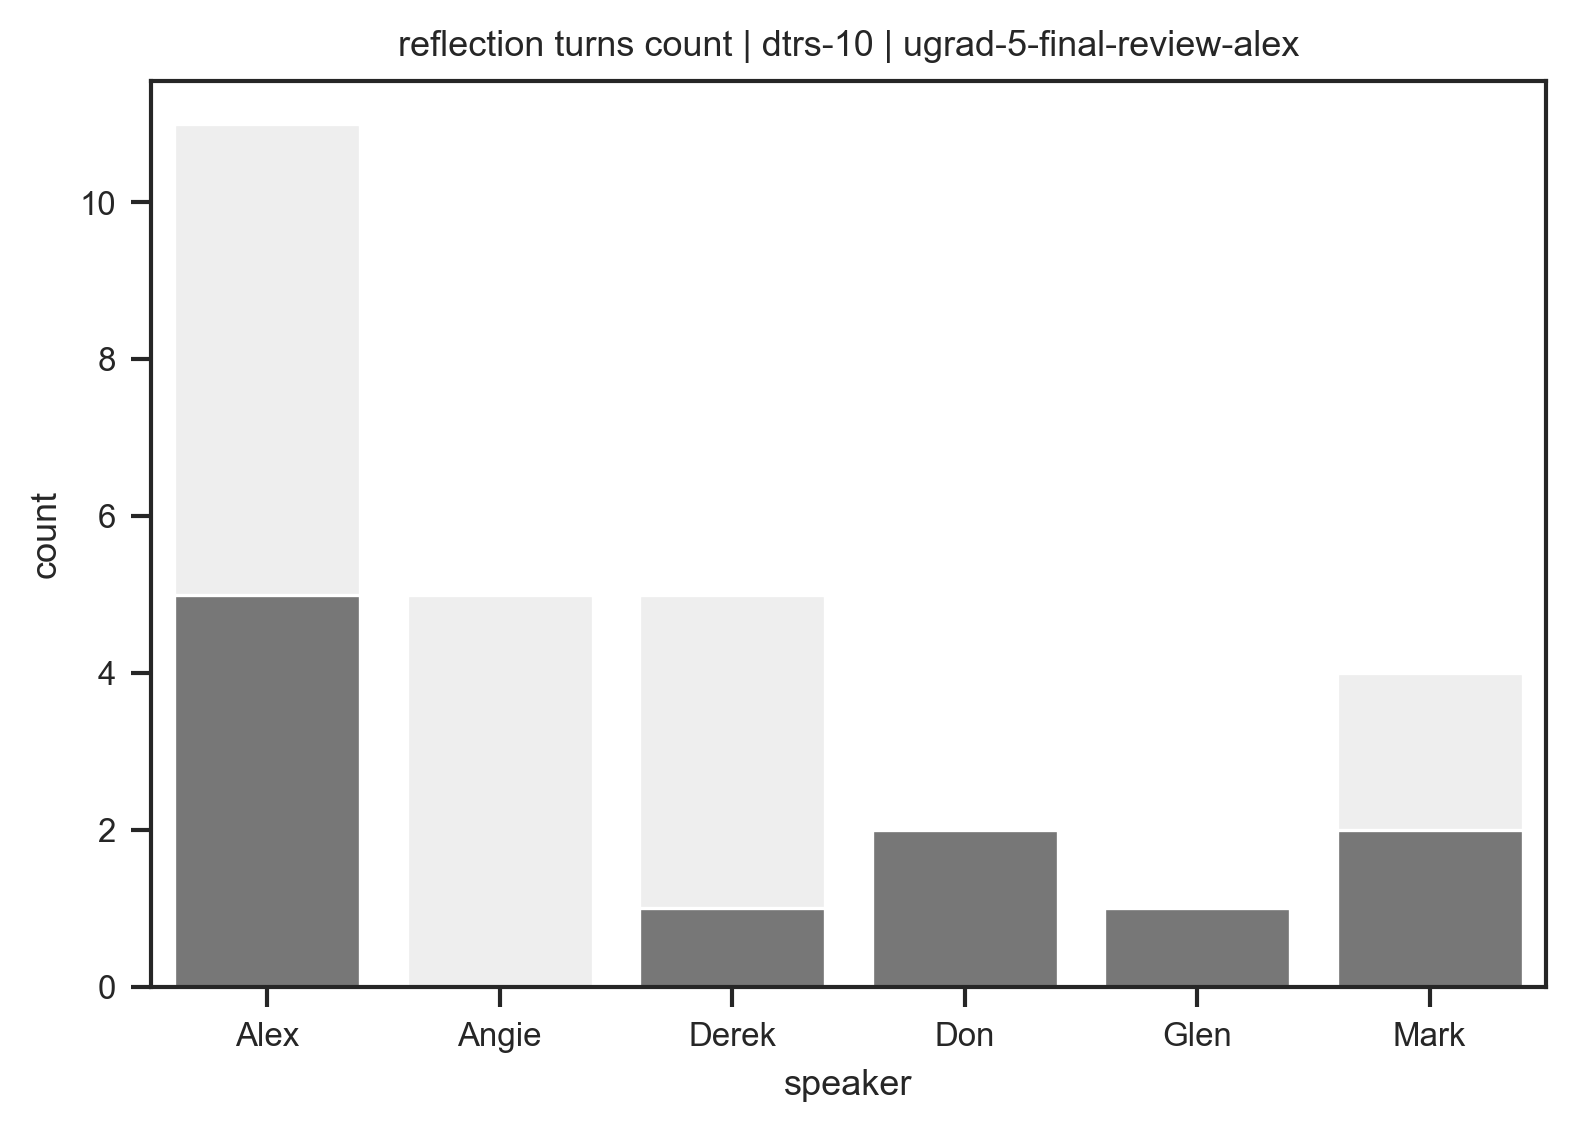

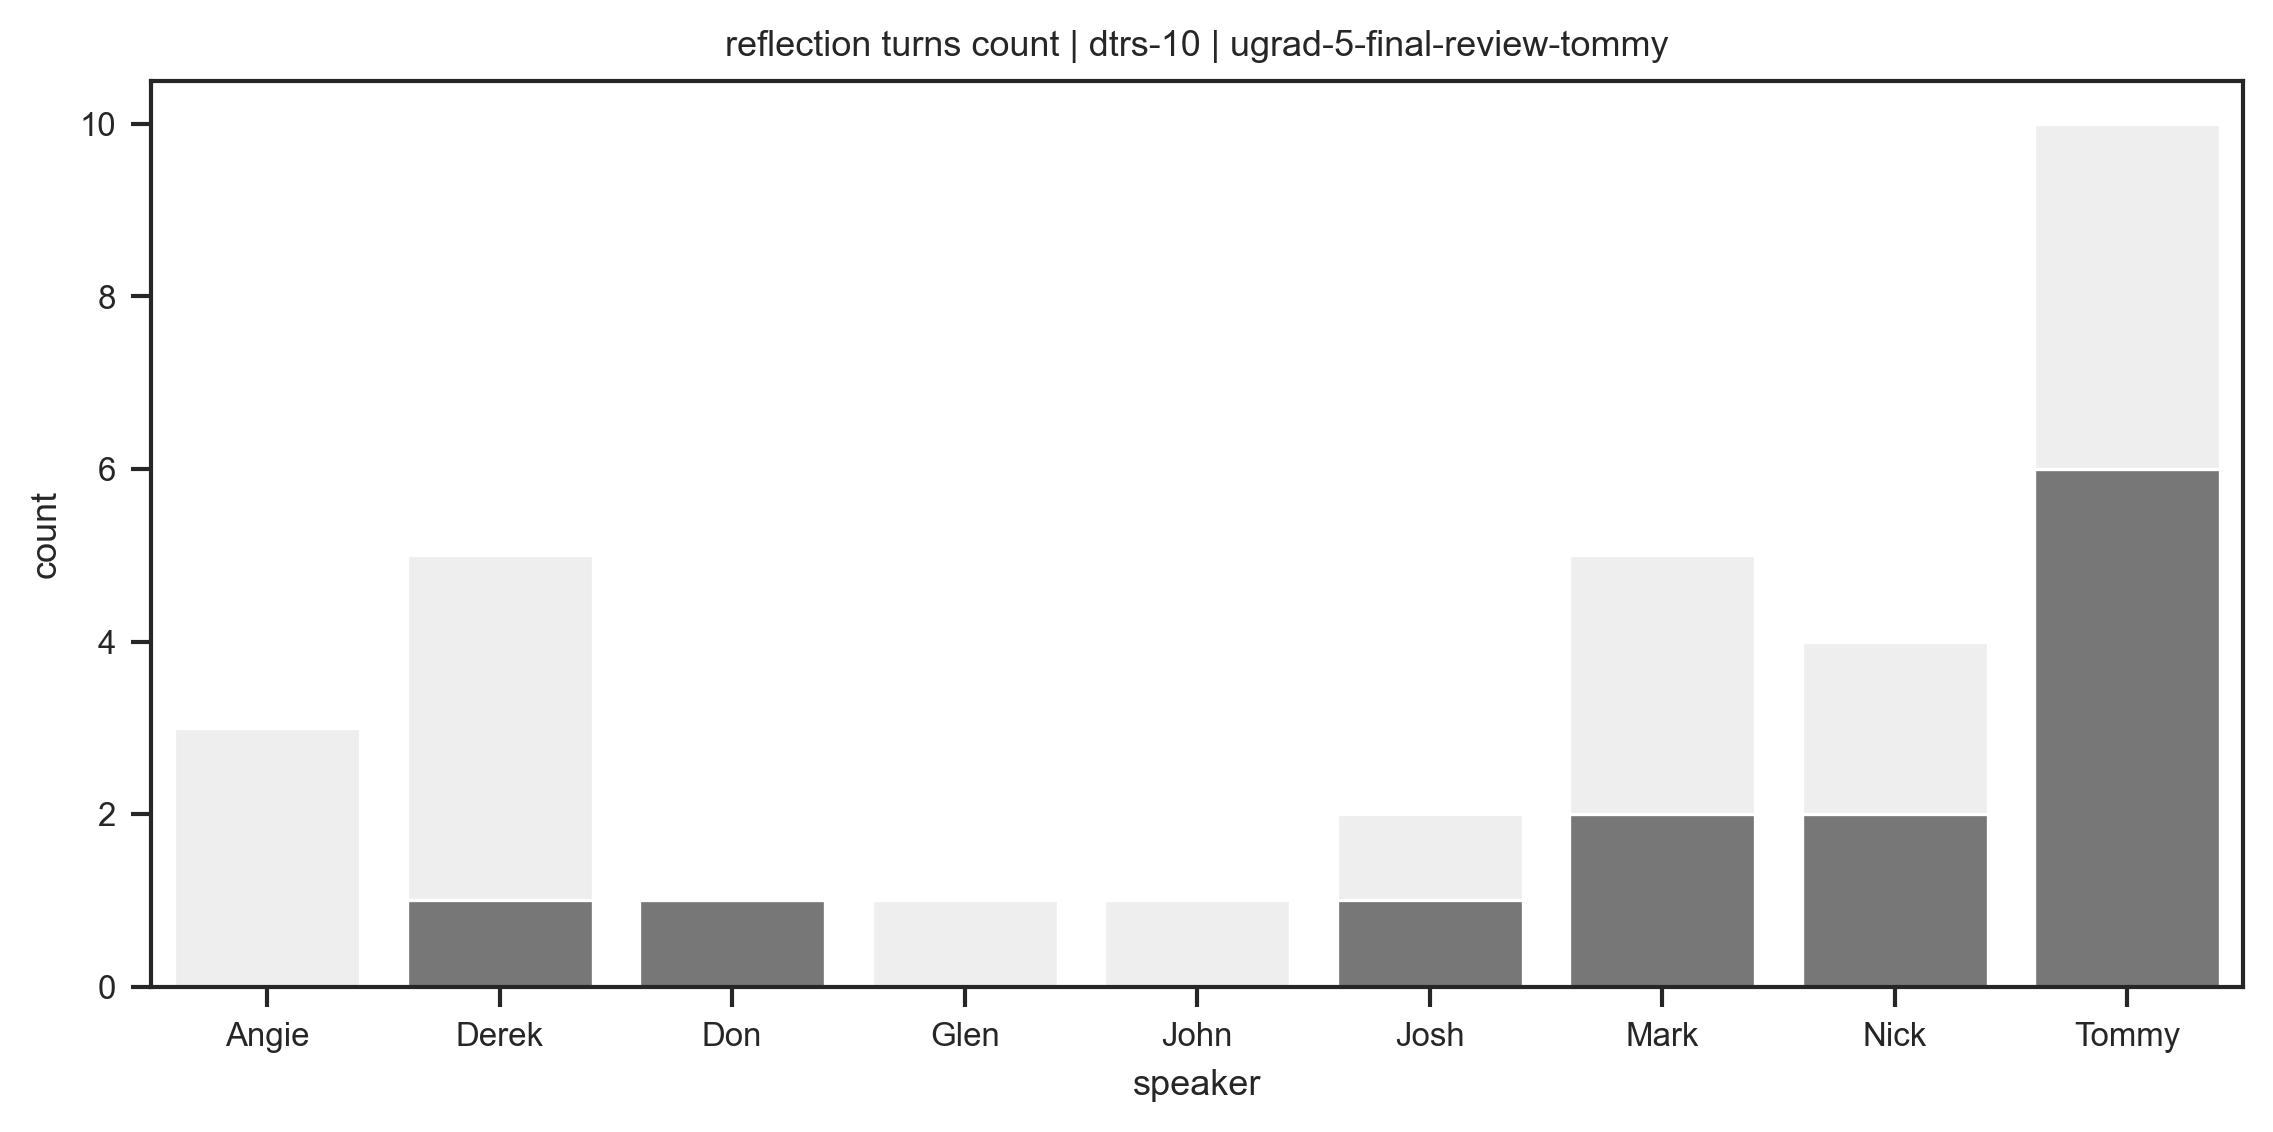

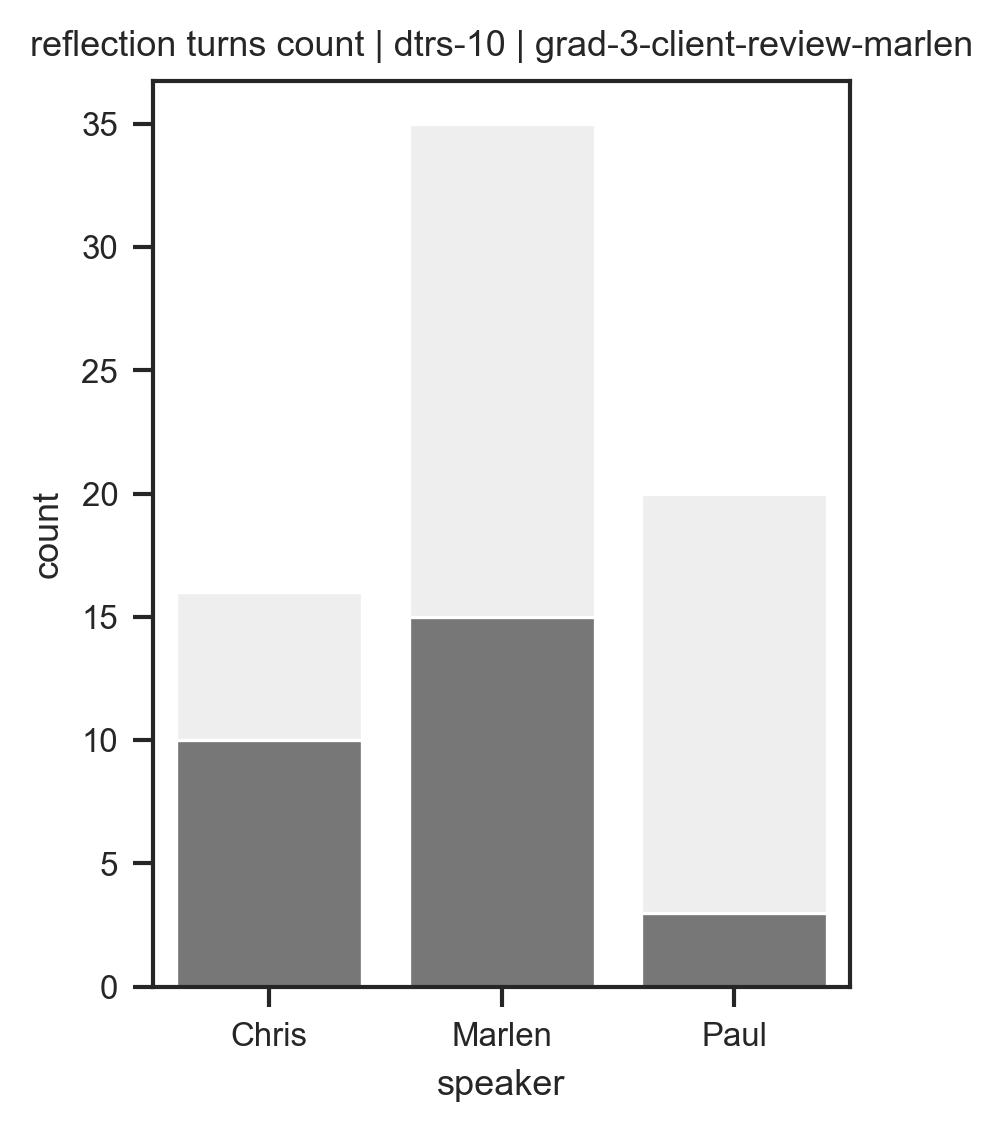

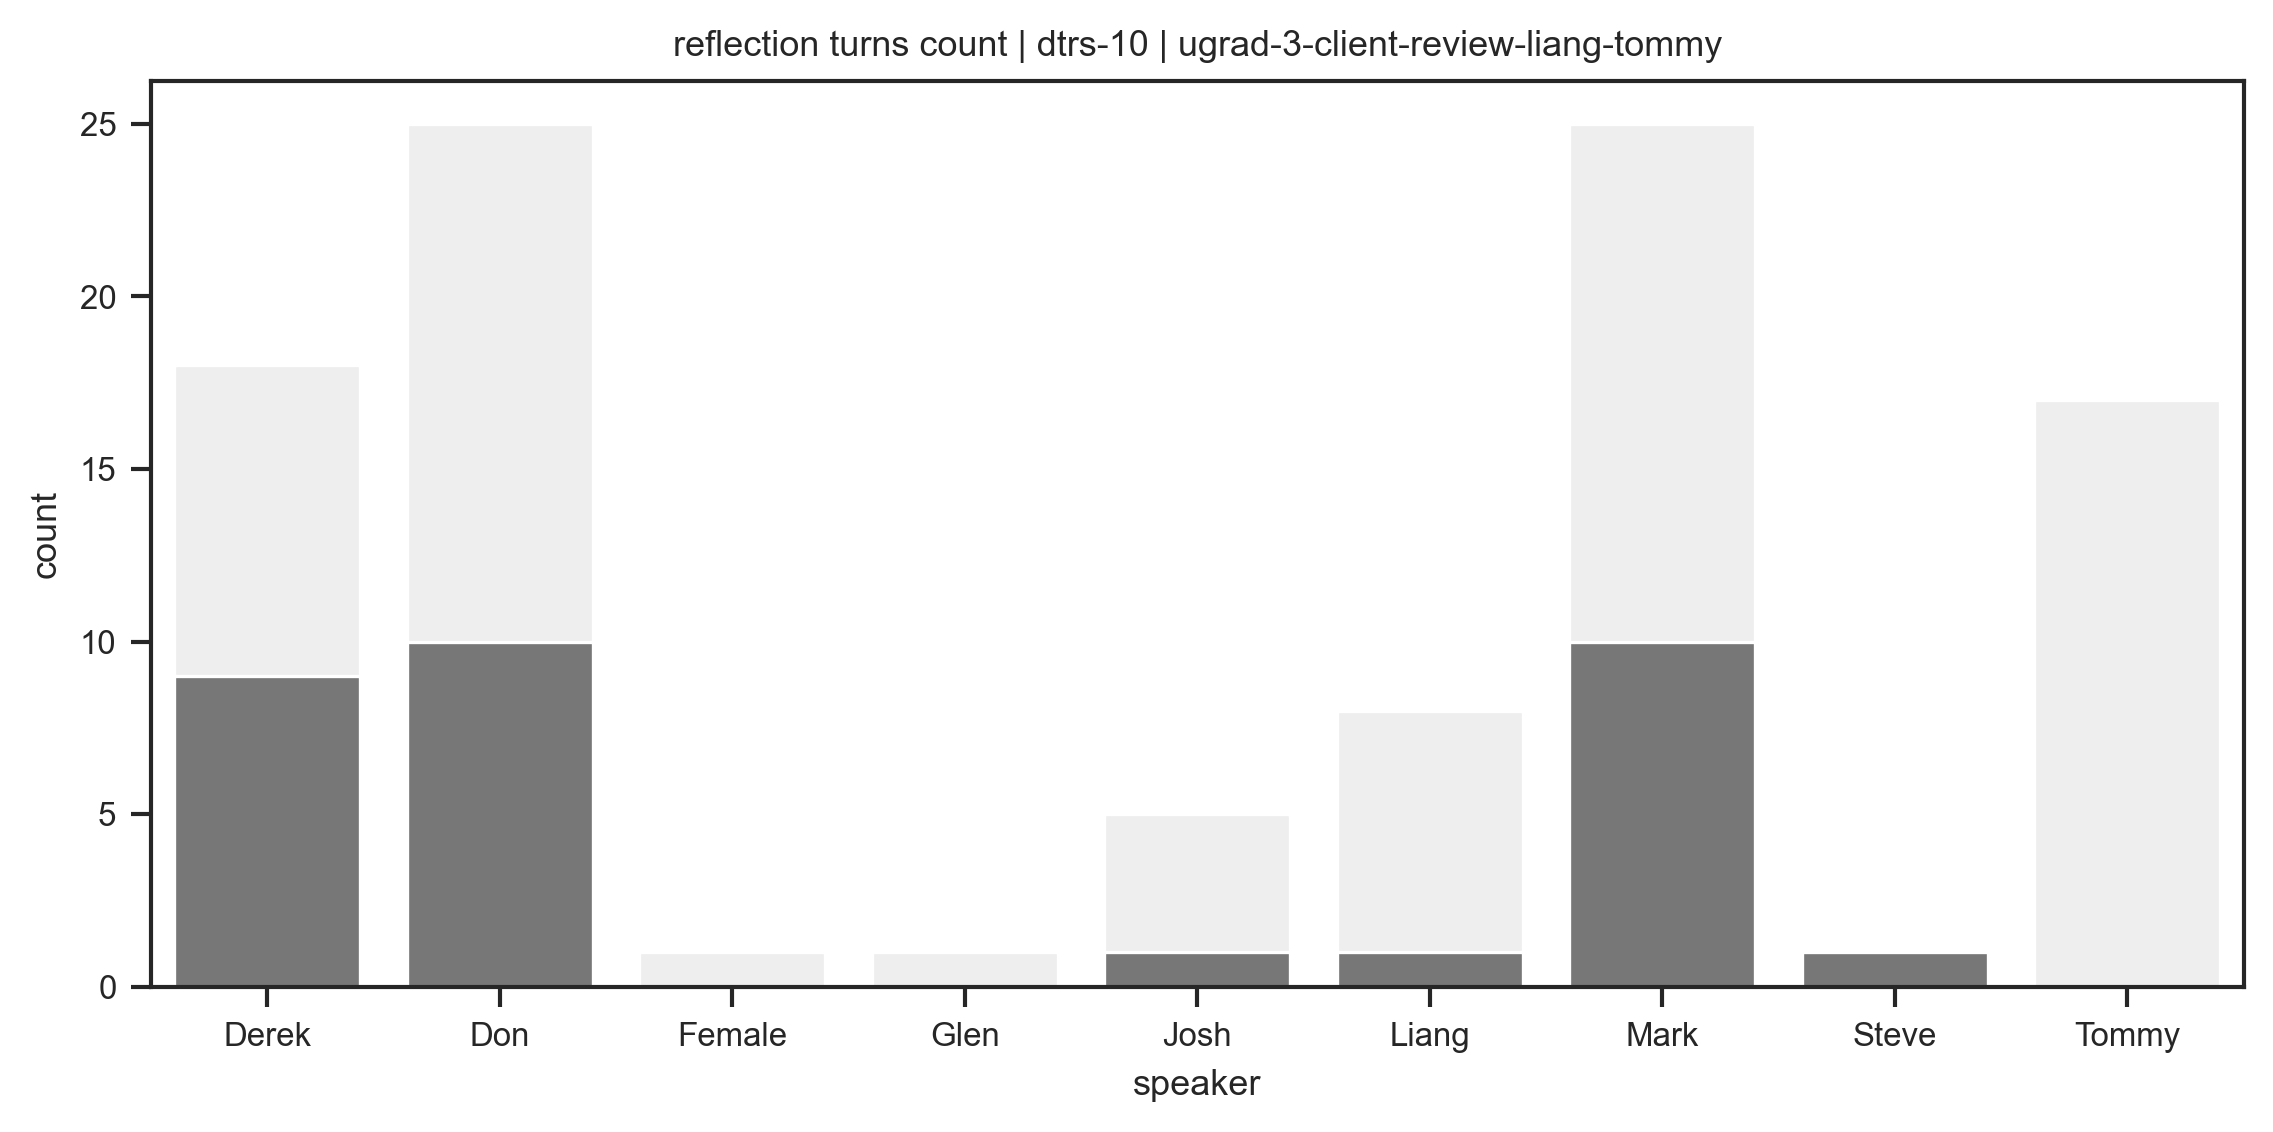

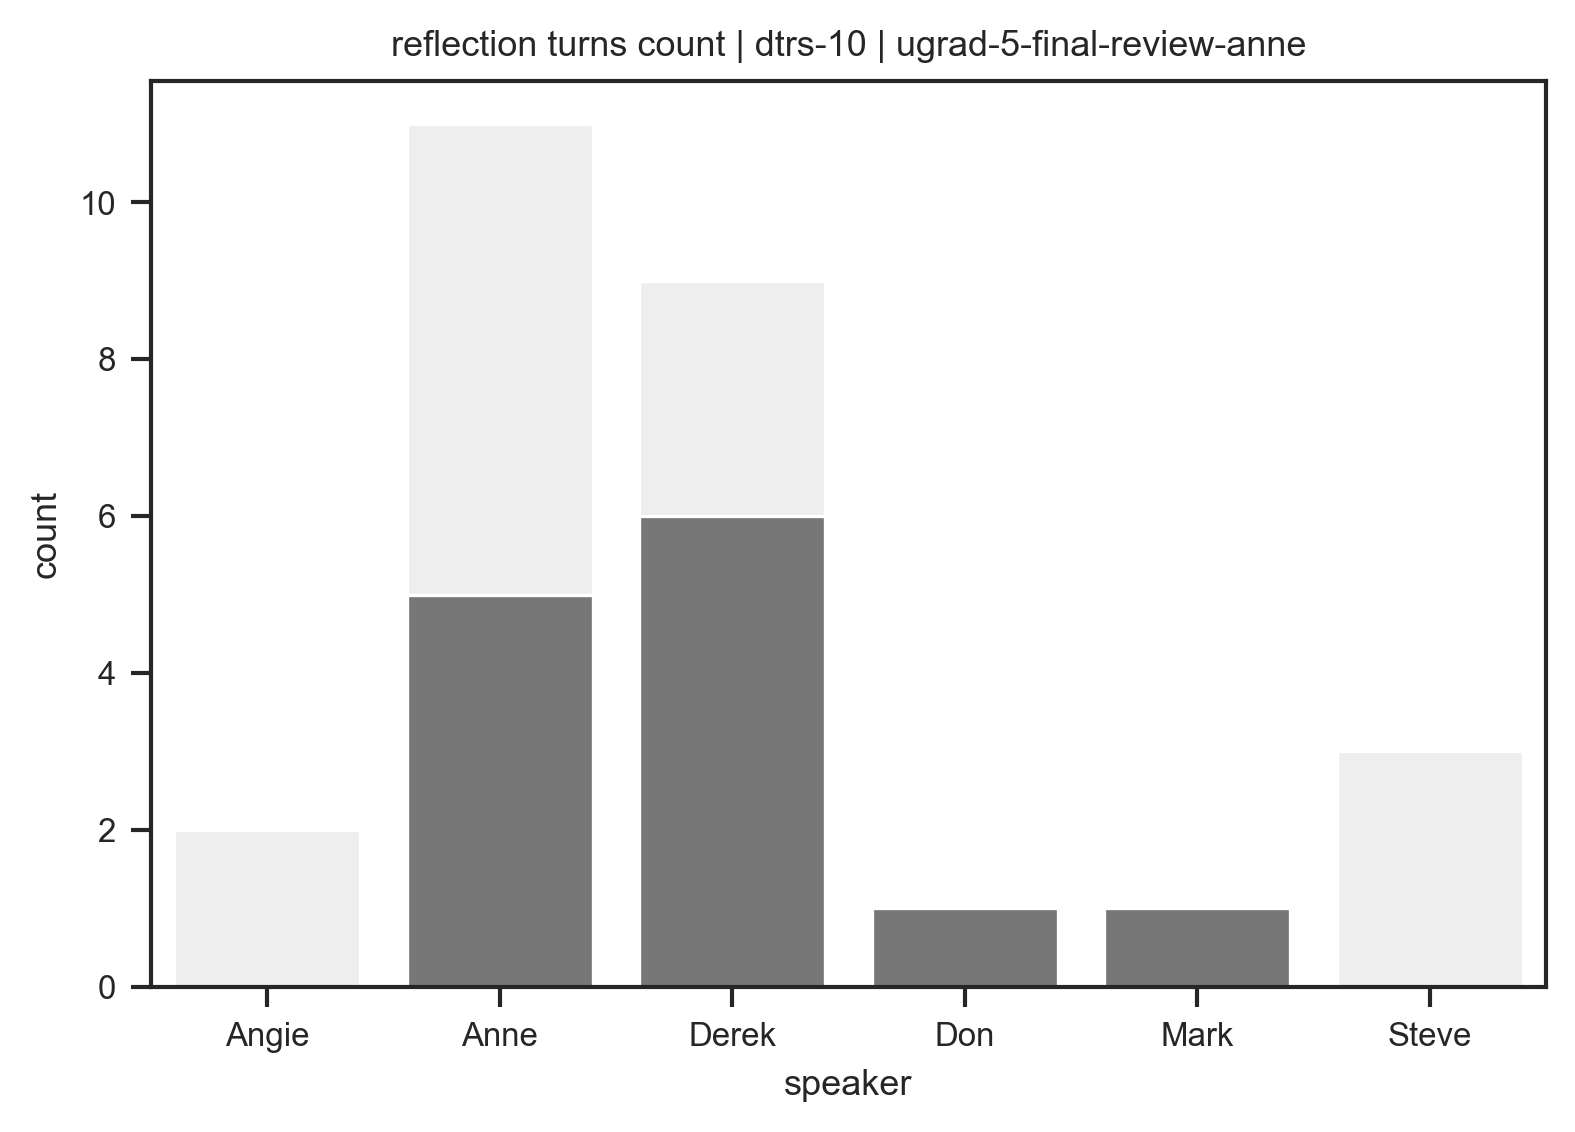

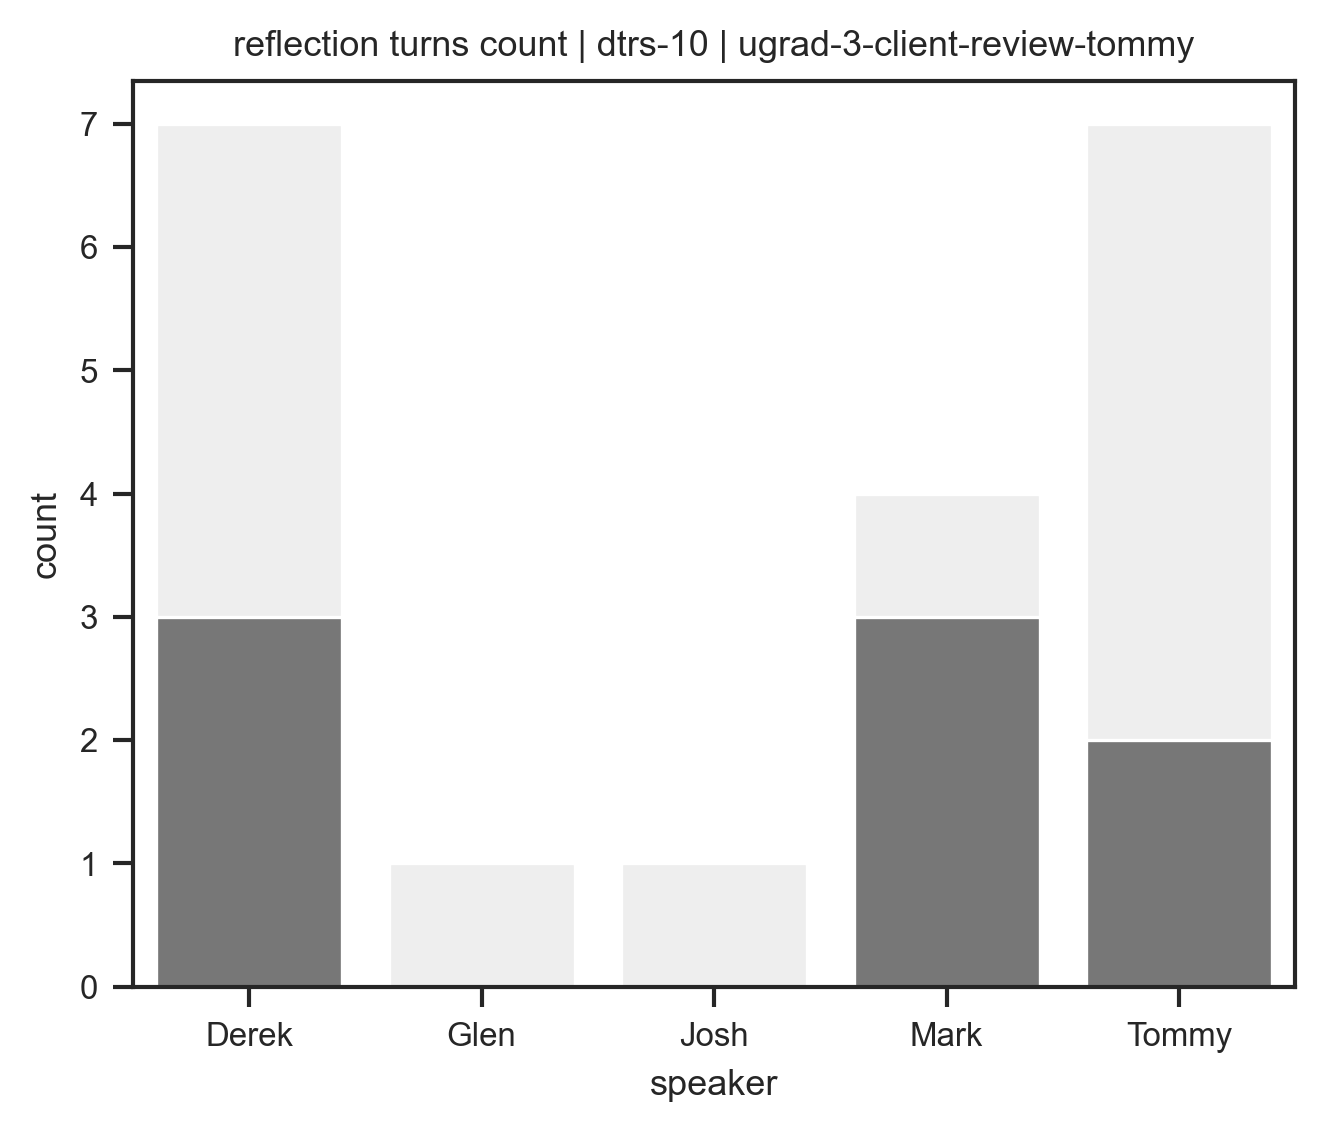

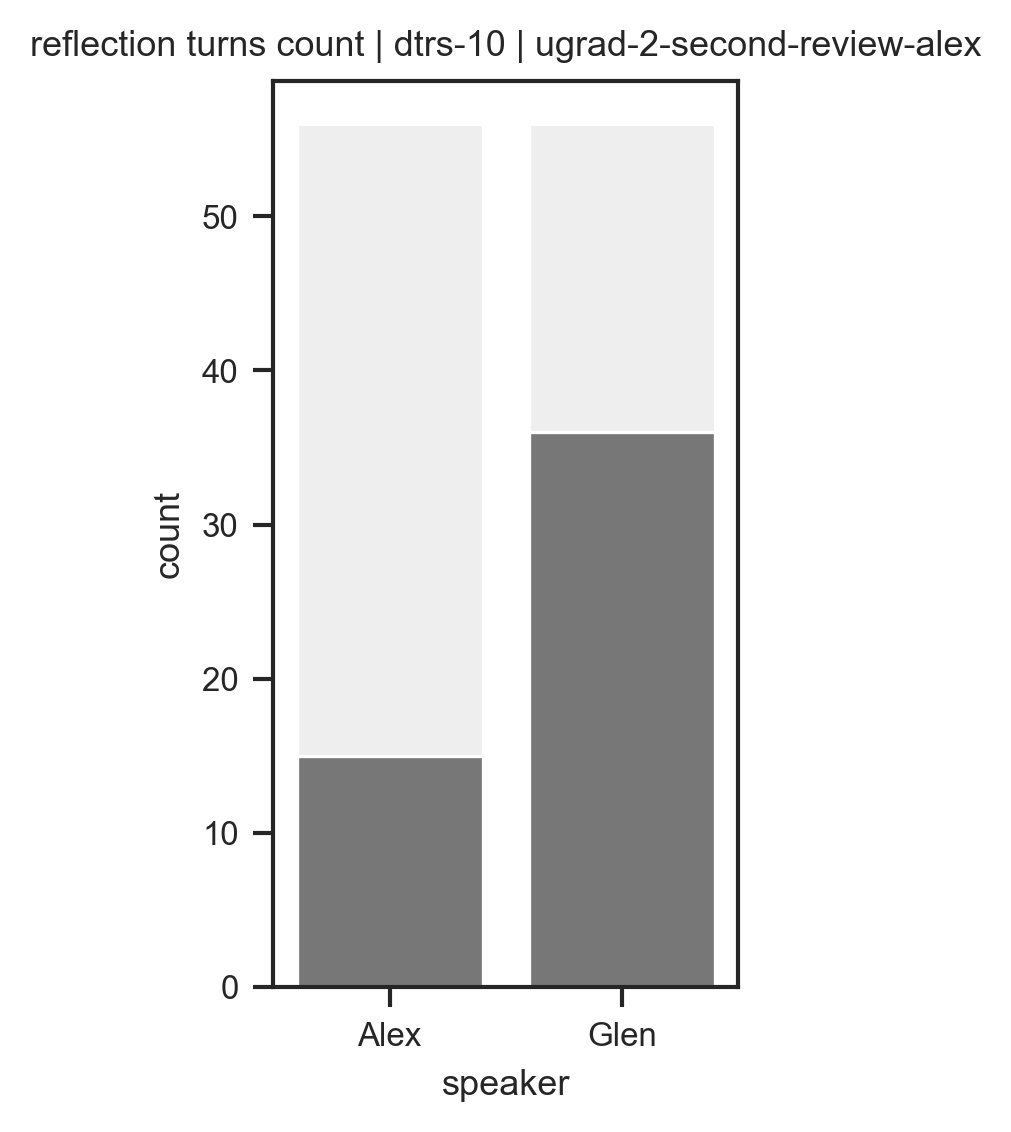

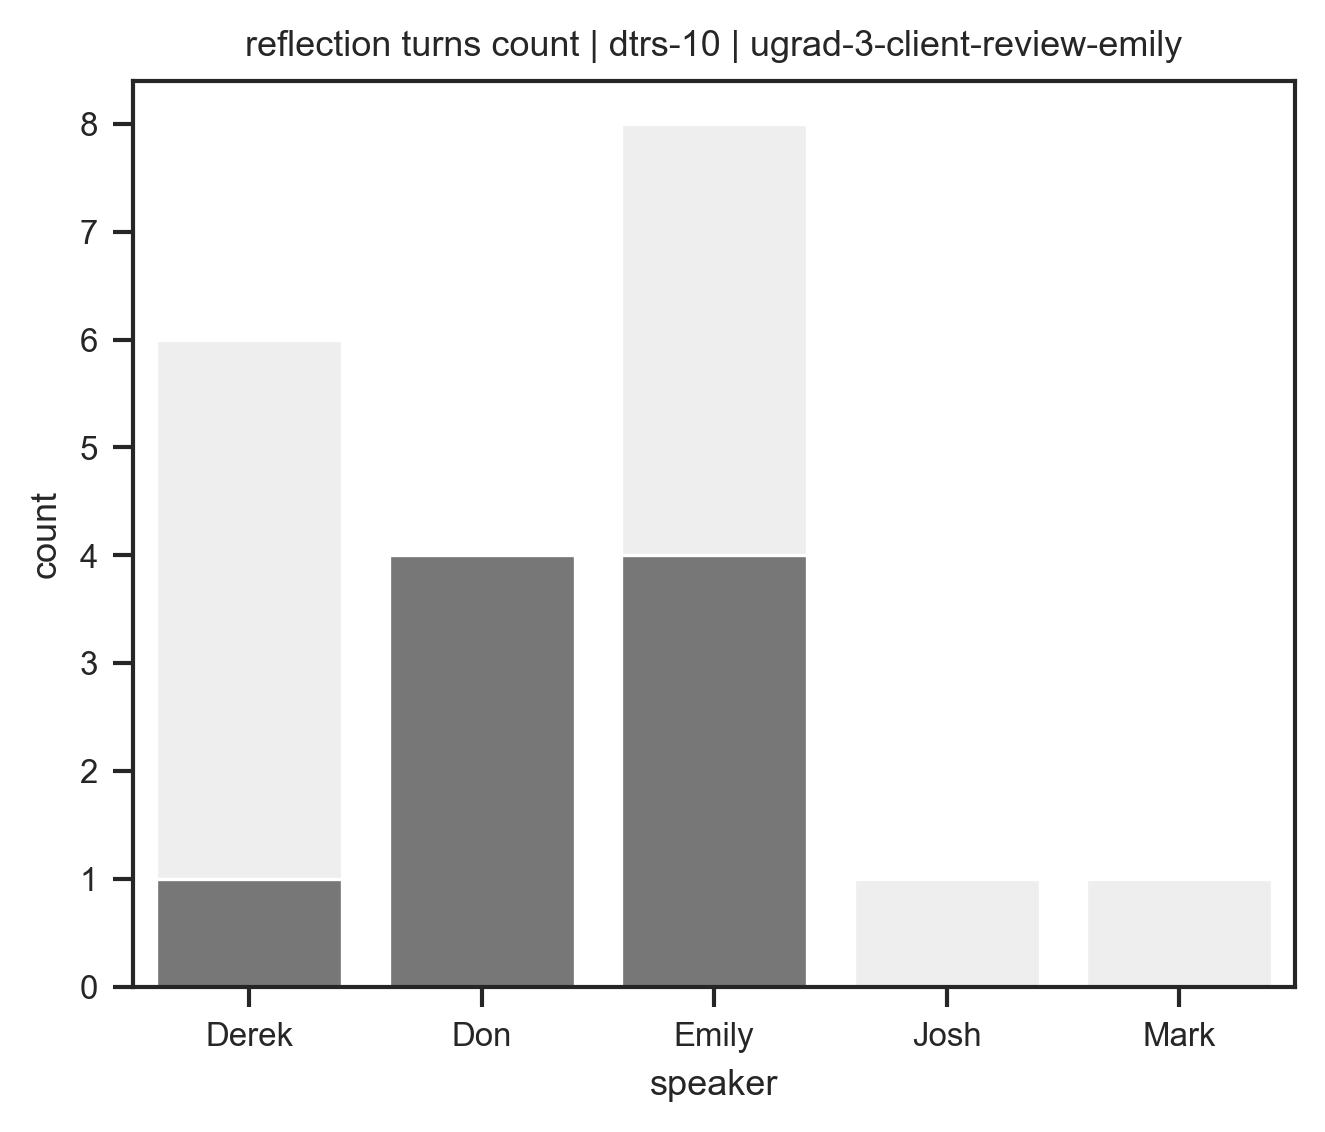

In [61]:
plot_cats_by_speaker(df, 'dtrs-10', 'reflection')

In [53]:
def plot_occurrences(input_df, dataset, session, category, range=[]):
    sns.set_style('ticks')
    sns.set_context("paper", font_scale=1.3)
    dataset_df = input_df[input_df['dataset'] == dataset]
    df_all = dataset_df[dataset_df['session'] == session]
    if len(range) == 0 :
        df = df_all.copy()
        start_turn = 0
    else :
        df = df_all[range[0]:range[1]]
        start_turn = range[0]
    category_color = '#777'
    none_color = '#eee'
    palette = [none_color, category_color]
    occurrences = []
    turns = []
    category_type = []
    category_occ = list(df[category])
    for ind, t in enumerate(category_occ) :
        if t > 0 : # category occurs in turn
            occ = 2
            kind = category
        else :
            occ = 1
            kind = 'none'
        category_type.append(kind)
        occurrences.append(occ)
        turns.append(ind + start_turn)
    df_plot = pd.DataFrame(list(zip(turns, occurrences, category_type)),
                           columns =['Turn', 'Category Index', 'Category'])
    fig = plt.figure(figsize=[20, 1], dpi=300)
    p = sns.scatterplot(data = df_plot, x = 'Turn', y = 'Category Index', hue='Category', 
                  hue_order = ['none', category], legend=False,
                  palette = palette, marker="|", s=200, lw=10)
#     plt.legend(bbox_to_anchor=(1.001, 1), loc=2)
    plt.ylim(0,3)
    plt.yticks([1,2], ['none', category])
    plt.savefig('plots/'+dataset+'-'+session+'-'+category +'-occurrence-timeline.pdf', bbox_inches='tight')
    plt.show()

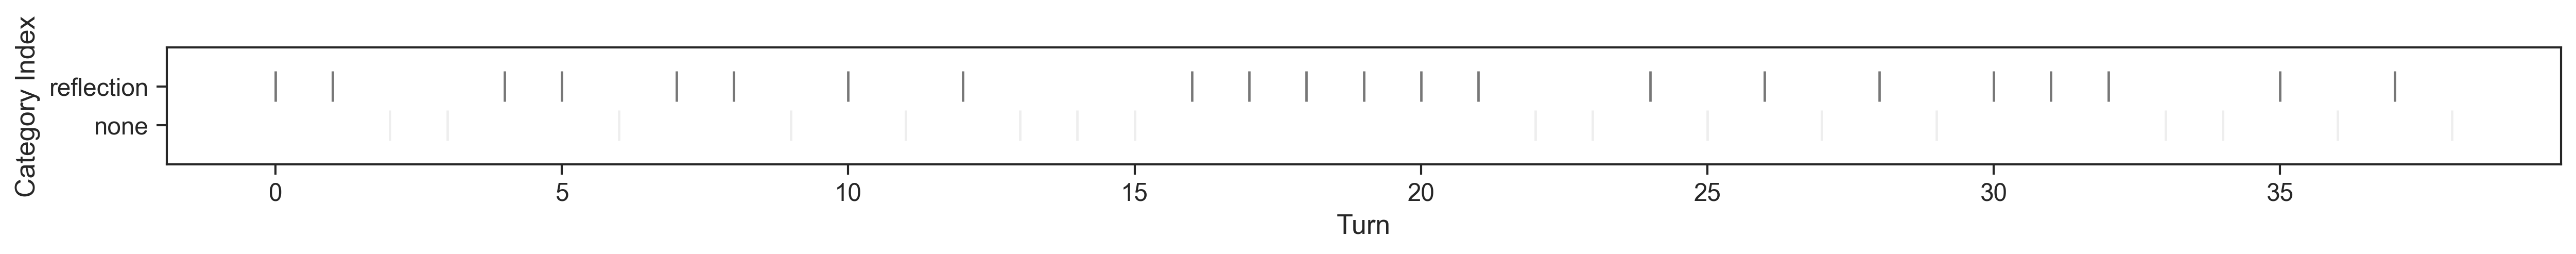

In [62]:
plot_occurrences(df, 'dtrs-10', 'ugrad-5-final-review-emily', 'reflection')

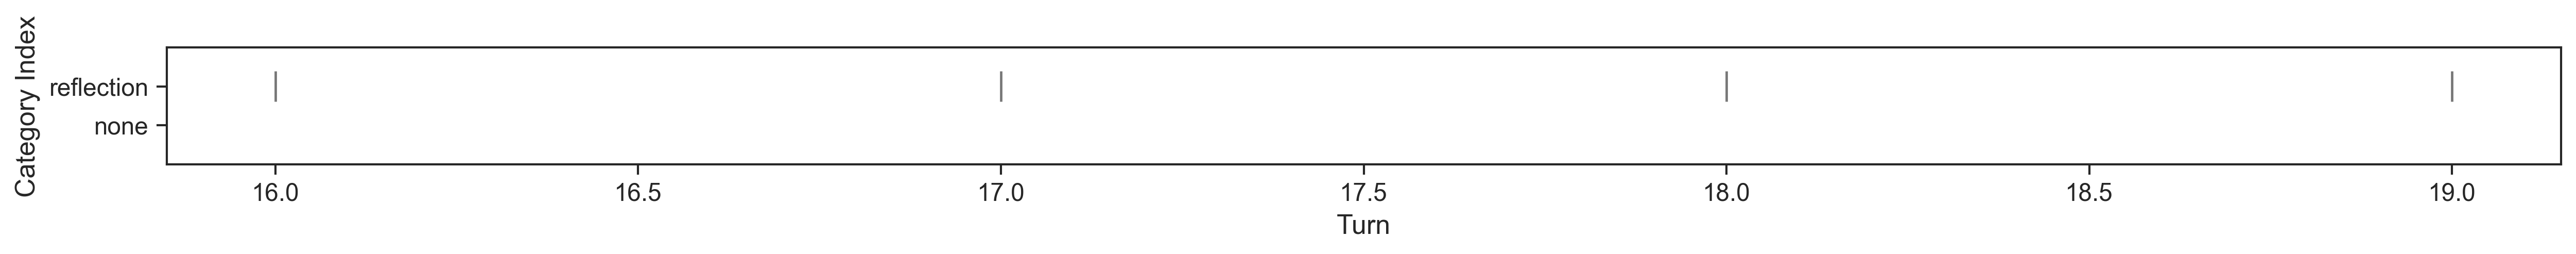

In [64]:
plot_occurrences(df, 'dtrs-10', 'ugrad-5-final-review-emily', 'reflection', range=[16,20])

In [65]:
def match_lexicon_terms(sentence, lexicon):
    reg_str = make_regex(lexicon)
    reg_matches = re.findall(reg_str, sentence.lower())
    reg_split = re.split(reg_str, sentence.lower())
    ind = 0
    matched_print = ""
    for split_string in reg_split:
        if ind == len(reg_matches) :
            str_to_concat = split_string
        else :
            str_to_concat = split_string + '**' + reg_matches[ind] + '**'
            ind += 1
        matched_print += str_to_concat
    return matched_print
    
def print_lines(df, dataset, session, lexicon, start, num_lines=10):
    df1 = df[df['dataset'] == dataset]
    df2 = df1[df1['session'] == session]
    speakers_list = list(df2['speaker'])
    utt = list(df2['utterance'])
    end = start + num_lines
    for ind, line in enumerate(utt[start:end]) :
        index = ind + start
        line_matched = match_lexicon_terms(line, lexicon)
        print(str(index)+' : ', end='')
        print(speakers_list[index])
        printmd(line_matched)
        print('----------')
        
def concordance(text, word, width=80, occurrences=10,nospace=False):
    margin = int((width - len(word))/2)
    start = 0
    counter = 0
    while start < len(text) or counter == occurrences:
        ind = text.find(word, start, -1)
        if ind < 0 :
            break
        
        if nospace : 
            
            if ind - margin > 0 :
                print(text[ind-margin:ind+len(word)+margin], ":", str(ind))
            else :
                spaces = ' ' * (margin - ind)
                print(spaces + text[0:ind+len(word)+margin], ":", str(ind))
            
        else :
            
            if ind - margin > 0 :
                left_text = text[ind-margin:ind]
                mid_text = text[ind:ind+len(word)]
                right_text = text[ind+len(word):ind+len(word)+margin]
            else :
                left_text = text[0:ind]
                mid_text = text[ind:ind+len(word)]
                right_text = text[ind+len(word):ind+len(word)+margin]
                
            print(left_text + "  " + mid_text + "  " + right_text, ":", str(ind))
            
        start += ind + len(word)
        counter += 1
        

def print_concordances(df, dataset, session, filter_keywords, match_limit=10, nospace=False):
    df1 = df[df['dataset'] == dataset]
    df2 = df1[df1['session'] == session]
    speakers_list = list(df2['speaker'])
    utt = list(df2['utterance'])
    utt_str = ' '.join(utt)
    if len(filter_keywords) > 0 :
        for term in filter_keywords :
            concordance(utt_str, term, width=80, occurrences=match_limit, nospace=nospace)
            print("-" * 80)

In [68]:
print_lines(df,  'dtrs-02', 'three-person-discussion', reflection_words, 450, num_lines=10)

TypeError: print_lines() got multiple values for argument 'num_lines'

In [58]:
lexicon.analyze("I guess I did something wrong", categories=["reflection"], normalize=True)
# => {'violence': 0.2}


{'reflection': 0.0}